<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/MNIST_28_isic_distribution_alexnet_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchextractor

In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset, random_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import torch.nn as nn


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/mnist"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

## Dataset and model setup

In [ ]:

import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms

class MnistDataset(Dataset):
    def __init__(self, path: str = None, is_two: int = None, data_files=None, labels=None, group_labels=None):
        self.resize_shape = (64, 64)  # Target shape for resizing images
        self.transform = transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images
        ])

        if path:  # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_two = is_two
            self.labels = [is_two] * len(self.data_files) if is_two is not None else labels
            self.group_labels = group_labels if group_labels else [None] * len(self.data_files)
        else:  # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.group_labels = group_labels if group_labels else [None] * len(data_files)
            self.is_two = is_two

    def __getitem__(self, i):
        # Read in the image
        img = Image.open(os.path.join(self.path, self.data_files[i])).convert("RGB")  # Convert to RGB
        if self.transform:
            img = self.transform(img)  # Apply transformations

        # Determine the label
        is_two = self.is_two if self.is_two is not None else self.labels[i]
        group_label = self.group_labels[i]

        return (img, is_two, group_label)

    def __len__(self):  # Returns the total number of images in the dataset.
        return len(self.data_files)



In [ ]:

import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # 96*55*55 (for 224x224 input)
            nn.MaxPool2d(kernel_size=3, stride=2),  # 96*27*27
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # 256*27*27
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*13*13
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 256*13*13
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*6*6
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(256 * 1 * 1, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)  # 1000 output

    def forward(self, x):
        x = self.layer1(x)
        #print("After layer1:", x.mean().item(), x.std().item())
        x = self.layer2(x)
        #print("After layer2:", x.mean().item(), x.std().item())
        x = self.layer3(x)
        #print("After layer3:", x.mean().item(), x.std().item())
        x = self.layer4(x)
        #print("After layer4:", x.mean().item(), x.std().item())
        x = self.layer5(x)
        #print("After layer5:", x.mean().item(), x.std().item())
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc1(x)
        #print("After fc1:", x.mean().item(), x.std().item())
        x = self.fc2(x)
        #print("After fc2:", x.mean().item(), x.std().item())
        x = self.fc3(x)
        #print("After fc3 (output):", x.mean().item(), x.std().item())
        return x


# Example usage:
# model = AlexNet()
# print(model)


## Training Function

In [ ]:

import torch.optim as optim
import torch.nn.functional as F
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, resume_training=False):
    since = time.time()
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Initialize best_model_wts with the current model state

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels, _ in tqdm(dataloaders[phase]):

                if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                    print("NaN or Inf found in input data!")
                    #continue  # Skip this batch if invalid values are found

                inputs = inputs.to(device)
                labels = labels.to(device)  # No need to convert labels for CrossEntropyLoss

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Use argmax for multi-class classification
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())

                if epoch_acc > best_accuracy:
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_accuracy = epoch_acc
                    print("Saving Best Model with Validation Accuracy: ", epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_accuracy:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model


## Train

### Original

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_0'
#two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
#zero_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'

#Test
test_two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))

dataset_test_two_bg = MnistDataset(path=test_two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_bg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_two_org))



# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_bg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_isic_org_cl0_cl2_{seed}" + "train.pt"))

### Background

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_0_half_first'
two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/background/train/class_2'
zero_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/background/train/class_0_half_second'

#Test
test_two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
#dataset_two_bg = MnistDataset(path=two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(two_bg_path)))
dataset_zero_bg = MnistDataset(path=zero_bg_path, is_two=0, group_labels=[3] * len(os.listdir(zero_bg_path)))
dataset_test_two_bg = MnistDataset(path=test_two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_bg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_bg, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_bg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 4933
num_val: 1234
num_test: 1032


Epoch 1/10
----------


100%|██████████| 78/78 [26:27<00:00, 20.35s/it]


train Loss: 3.4035 Acc: 0.9059


100%|██████████| 20/20 [06:51<00:00, 20.58s/it]


val Loss: 0.0256 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9975688816855753
Epoch 2/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.65it/s]


train Loss: 0.0213 Acc: 0.9964


100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


val Loss: 0.0127 Acc: 0.9968
Epoch 3/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.73it/s]


train Loss: 0.0125 Acc: 0.9984


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


val Loss: 0.0099 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991896272285251
Epoch 4/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.65it/s]


train Loss: 0.0090 Acc: 0.9986


100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


val Loss: 0.0071 Acc: 1.0000
Saving Best Model with Validation Accuracy:  1.0
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.62it/s]


train Loss: 0.0066 Acc: 0.9994


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


val Loss: 0.0059 Acc: 1.0000
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.51it/s]


train Loss: 0.0053 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.52it/s]


val Loss: 0.0051 Acc: 1.0000
Epoch 7/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.61it/s]


train Loss: 0.0042 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


val Loss: 0.0045 Acc: 1.0000
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.62it/s]


train Loss: 0.0035 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.63it/s]


val Loss: 0.0040 Acc: 1.0000
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.68it/s]


train Loss: 0.0030 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


val Loss: 0.0039 Acc: 1.0000
Epoch 10/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.35it/s]


train Loss: 0.0027 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


val Loss: 0.0033 Acc: 1.0000
Training complete in 35m 15s
Best Validation Accuracy: 1.0000


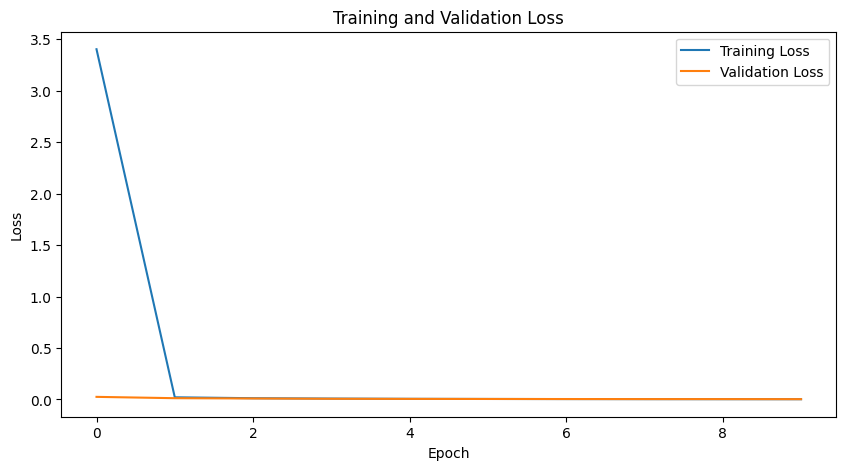

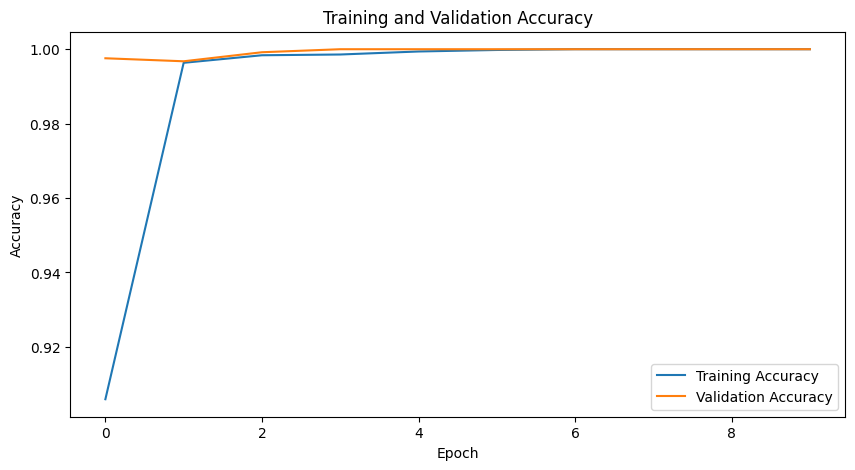

Epoch 1/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.37it/s]


train Loss: 2.3329 Acc: 0.9195


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


val Loss: 0.0193 Acc: 0.9927
Saving Best Model with Validation Accuracy:  0.992706645056726
Epoch 2/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.64it/s]


train Loss: 0.0101 Acc: 0.9976


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


val Loss: 0.0078 Acc: 0.9968
Saving Best Model with Validation Accuracy:  0.9967585089141004
Epoch 3/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.66it/s]


train Loss: 0.0053 Acc: 0.9994


100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


val Loss: 0.0071 Acc: 0.9968
Epoch 4/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.63it/s]


train Loss: 0.0038 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


val Loss: 0.0054 Acc: 0.9984
Saving Best Model with Validation Accuracy:  0.9983792544570502
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.65it/s]


train Loss: 0.0028 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


val Loss: 0.0066 Acc: 0.9968
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.48it/s]


train Loss: 0.0025 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


val Loss: 0.0044 Acc: 0.9984
Epoch 7/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.51it/s]


train Loss: 0.0020 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


val Loss: 0.0055 Acc: 0.9968
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.59it/s]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


val Loss: 0.0040 Acc: 0.9984
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.58it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


val Loss: 0.0040 Acc: 0.9984
Epoch 10/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.51it/s]


train Loss: 0.0013 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


val Loss: 0.0040 Acc: 0.9976
Training complete in 2m 9s
Best Validation Accuracy: 0.9984


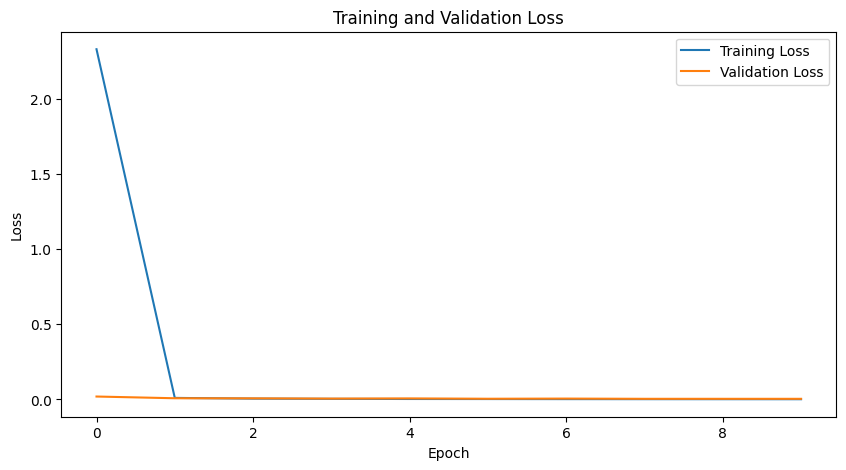

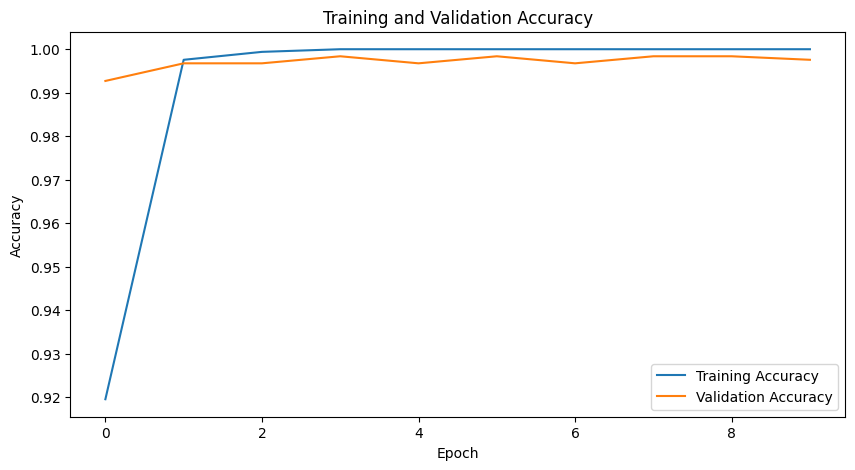

Epoch 1/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.57it/s]


train Loss: 2.2333 Acc: 0.9130


100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


val Loss: 0.0107 Acc: 0.9984
Saving Best Model with Validation Accuracy:  0.9983792544570502
Epoch 2/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.76it/s]


train Loss: 0.0099 Acc: 0.9974


100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


val Loss: 0.0073 Acc: 0.9984
Epoch 3/10
----------


100%|██████████| 78/78 [00:09<00:00,  7.84it/s]


train Loss: 0.0059 Acc: 0.9988


100%|██████████| 20/20 [00:02<00:00,  7.13it/s]


val Loss: 0.0059 Acc: 0.9984
Epoch 4/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.66it/s]


train Loss: 0.0042 Acc: 0.9994


100%|██████████| 20/20 [00:02<00:00,  7.17it/s]


val Loss: 0.0048 Acc: 0.9984
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.68it/s]


train Loss: 0.0033 Acc: 0.9996


100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


val Loss: 0.0041 Acc: 0.9984
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.74it/s]


train Loss: 0.0025 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.24it/s]


val Loss: 0.0036 Acc: 0.9984
Epoch 7/10
----------


100%|██████████| 78/78 [00:09<00:00,  7.96it/s]


train Loss: 0.0021 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.02it/s]


val Loss: 0.0032 Acc: 1.0000
Saving Best Model with Validation Accuracy:  1.0
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.69it/s]


train Loss: 0.0018 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.15it/s]


val Loss: 0.0029 Acc: 1.0000
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.63it/s]


train Loss: 0.0016 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.23it/s]


val Loss: 0.0027 Acc: 1.0000
Epoch 10/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.67it/s]


train Loss: 0.0014 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


val Loss: 0.0025 Acc: 1.0000
Training complete in 2m 9s
Best Validation Accuracy: 1.0000


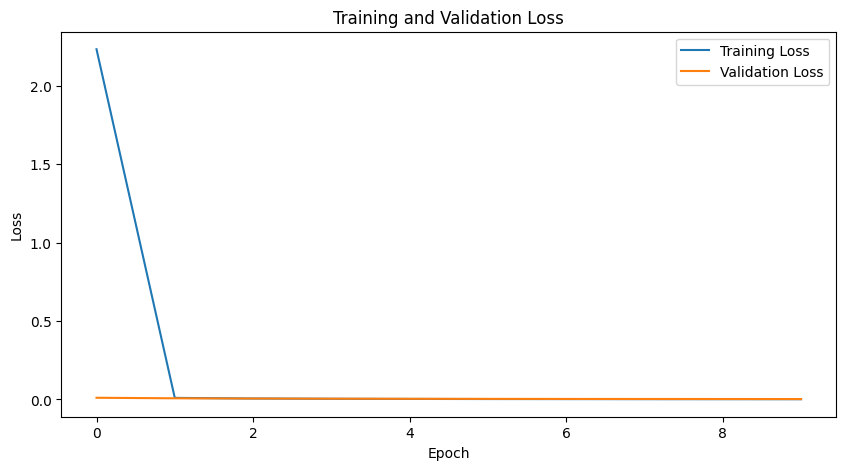

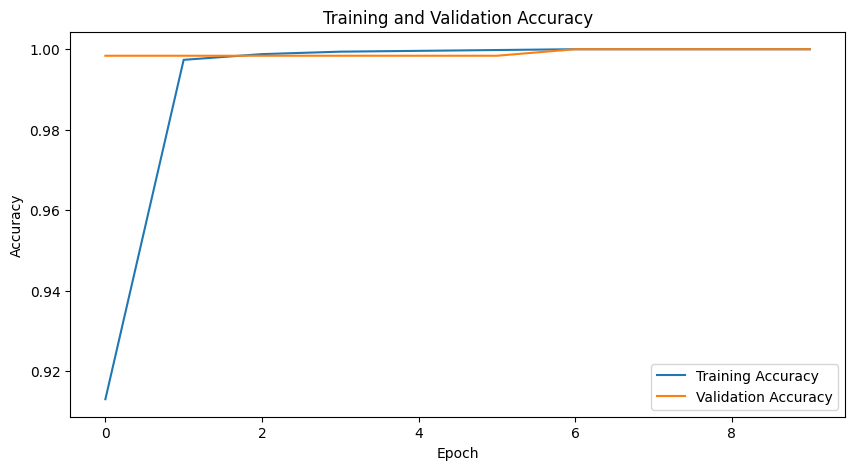

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_isic_bg_cl0_cl2_{seed}" + "train.pt"))

### Foreground

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_0_half_first' #first half
#two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/foreground/train/class_2'
zero_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/foreground/train/class_0_half_second' #second half

#Test
test_two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
#dataset_two_fg = MnistDataset(path=two_fg_path, is_two=1, group_labels=[1] * len(os.listdir(two_fg_path)))
dataset_zero_fg = MnistDataset(path=zero_fg_path, is_two=0, group_labels=[3] * len(os.listdir(zero_fg_path)))
dataset_test_two_fg = MnistDataset(path=test_two_fg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_fg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_fg, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_fg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 4933
num_val: 1234
num_test: 1032


Epoch 1/10
----------


100%|██████████| 78/78 [12:32<00:00,  9.65s/it]


train Loss: 3.2335 Acc: 0.9019


100%|██████████| 20/20 [03:25<00:00, 10.27s/it]


val Loss: 0.0307 Acc: 0.9935
Saving Best Model with Validation Accuracy:  0.9935170178282009
Epoch 2/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.53it/s]


train Loss: 0.0224 Acc: 0.9941


100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


val Loss: 0.0120 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9975688816855753
Epoch 3/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.62it/s]


train Loss: 0.0132 Acc: 0.9976


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


val Loss: 0.0107 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991896272285251
Epoch 4/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.39it/s]


train Loss: 0.0097 Acc: 0.9984


100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


val Loss: 0.0065 Acc: 0.9992
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.54it/s]


train Loss: 0.0070 Acc: 0.9994


100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


val Loss: 0.0055 Acc: 1.0000
Saving Best Model with Validation Accuracy:  1.0
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.53it/s]


train Loss: 0.0056 Acc: 0.9996


100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


val Loss: 0.0045 Acc: 1.0000
Epoch 7/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.51it/s]


train Loss: 0.0045 Acc: 0.9996


100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


val Loss: 0.0044 Acc: 1.0000
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.53it/s]


train Loss: 0.0036 Acc: 0.9996


100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


val Loss: 0.0038 Acc: 1.0000
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.61it/s]


train Loss: 0.0031 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


val Loss: 0.0034 Acc: 0.9992
Epoch 10/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.56it/s]


train Loss: 0.0028 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


val Loss: 0.0029 Acc: 1.0000
Training complete in 17m 55s
Best Validation Accuracy: 1.0000


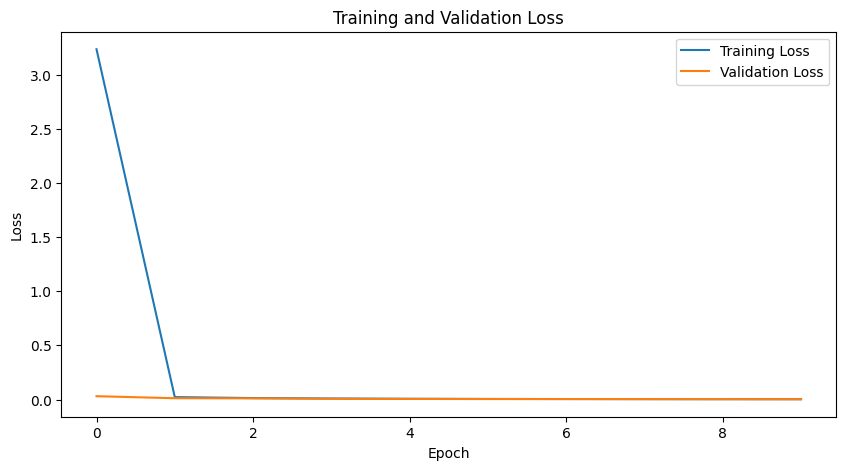

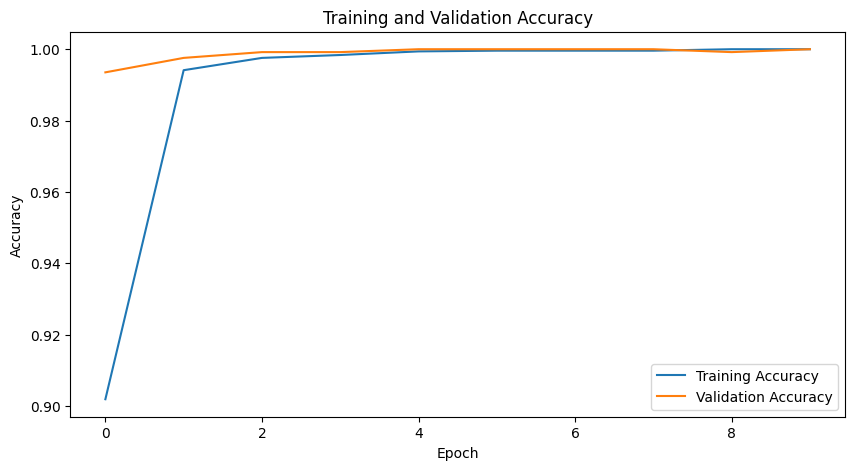

Epoch 1/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.56it/s]


train Loss: 1.1603 Acc: 0.9548


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


val Loss: 0.0134 Acc: 0.9951
Saving Best Model with Validation Accuracy:  0.9951377633711507
Epoch 2/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.57it/s]


train Loss: 0.0095 Acc: 0.9966


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


val Loss: 0.0074 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9975688816855753
Epoch 3/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.39it/s]


train Loss: 0.0041 Acc: 0.9988


100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


val Loss: 0.0048 Acc: 0.9984
Saving Best Model with Validation Accuracy:  0.9983792544570502
Epoch 4/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.52it/s]


train Loss: 0.0016 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


val Loss: 0.0044 Acc: 0.9976
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.54it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


val Loss: 0.0042 Acc: 0.9976
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.69it/s]


train Loss: 0.0015 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


val Loss: 0.0042 Acc: 0.9976
Epoch 7/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.50it/s]


train Loss: 0.0010 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


val Loss: 0.0045 Acc: 0.9976
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.62it/s]


train Loss: 0.0009 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


val Loss: 0.0037 Acc: 0.9976
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.65it/s]


train Loss: 0.0008 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


val Loss: 0.0036 Acc: 0.9984
Epoch 10/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.60it/s]


train Loss: 0.0007 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


val Loss: 0.0037 Acc: 0.9976
Training complete in 2m 9s
Best Validation Accuracy: 0.9984


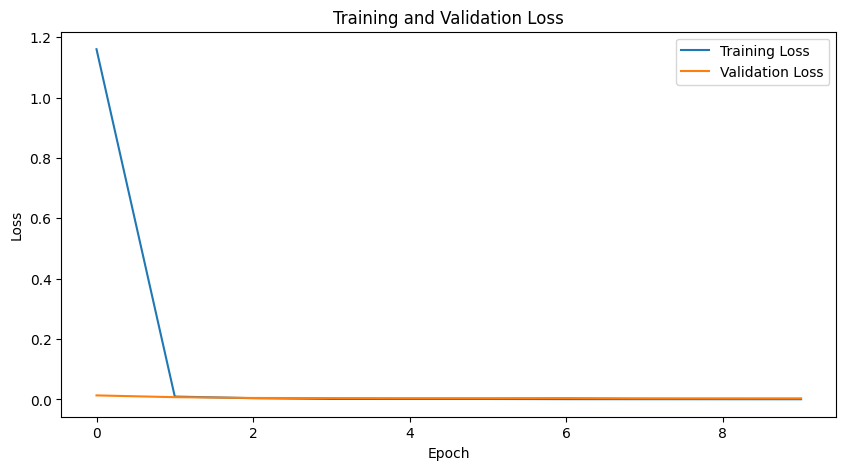

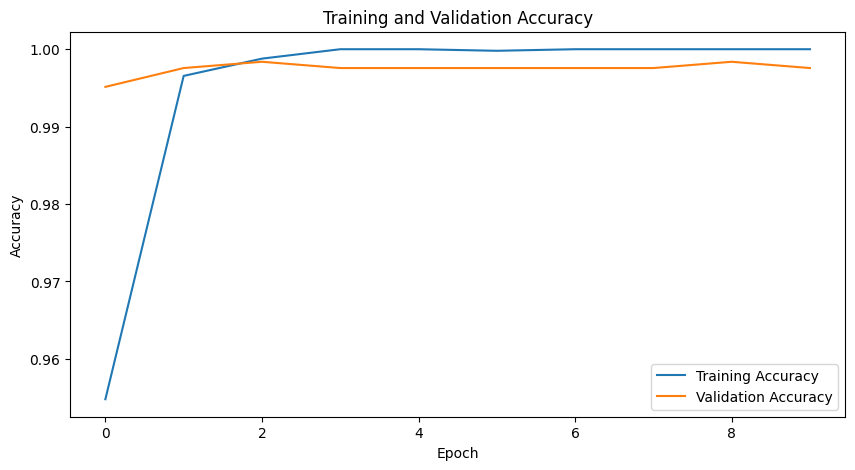

Epoch 1/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.64it/s]


train Loss: 2.2694 Acc: 0.9171


100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


val Loss: 0.0211 Acc: 0.9935
Saving Best Model with Validation Accuracy:  0.9935170178282009
Epoch 2/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.61it/s]


train Loss: 0.0140 Acc: 0.9968


100%|██████████| 20/20 [00:02<00:00,  7.58it/s]


val Loss: 0.0120 Acc: 0.9968
Saving Best Model with Validation Accuracy:  0.9967585089141004
Epoch 3/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.41it/s]


train Loss: 0.0081 Acc: 0.9984


100%|██████████| 20/20 [00:02<00:00,  7.25it/s]


val Loss: 0.0075 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9975688816855753
Epoch 4/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.40it/s]


train Loss: 0.0054 Acc: 0.9992


100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


val Loss: 0.0056 Acc: 0.9984
Saving Best Model with Validation Accuracy:  0.9983792544570502
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.42it/s]


train Loss: 0.0038 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


val Loss: 0.0048 Acc: 0.9984
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.59it/s]


train Loss: 0.0031 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


val Loss: 0.0041 Acc: 0.9984
Epoch 7/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.51it/s]


train Loss: 0.0025 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


val Loss: 0.0036 Acc: 0.9984
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.59it/s]


train Loss: 0.0020 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


val Loss: 0.0033 Acc: 1.0000
Saving Best Model with Validation Accuracy:  1.0
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.71it/s]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


val Loss: 0.0030 Acc: 1.0000
Epoch 10/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.54it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


val Loss: 0.0027 Acc: 1.0000
Training complete in 2m 10s
Best Validation Accuracy: 1.0000


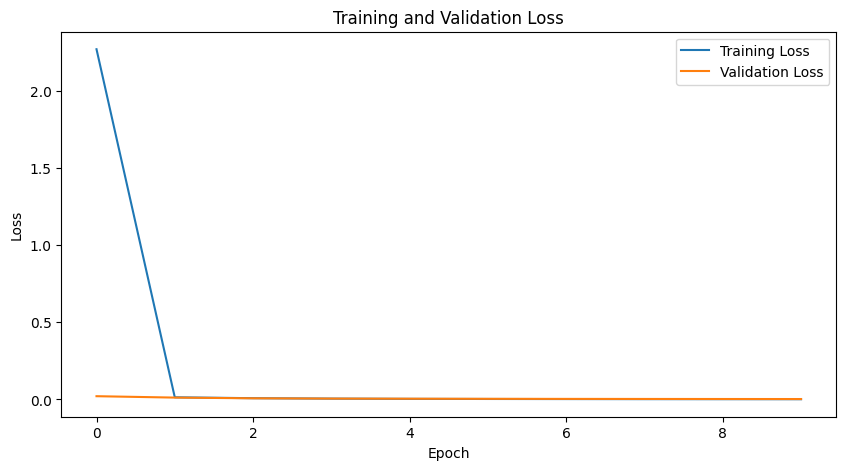

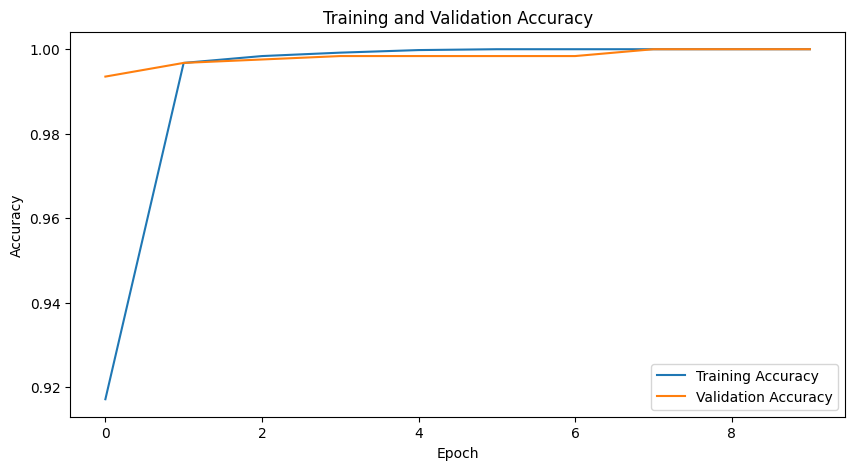

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_isic_fg_cl0_cl2_{seed}" + "train.pt"))

### Left Patch

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_0_half_first'
#two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2'
zero_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/patches_left/train/class_0_half_second'

#Test
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
#dataset_two_lp = MnistDataset(path=two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(two_lp_path)))
dataset_zero_lp = MnistDataset(path=zero_lp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_lp_path)))
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_lp, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_lp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 4933
num_val: 1234
num_test: 1032


Epoch 1/10
----------


100%|██████████| 78/78 [10:58<00:00,  8.44s/it]


train Loss: 3.5958 Acc: 0.8988


100%|██████████| 20/20 [02:49<00:00,  8.50s/it]


val Loss: 0.0304 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9975688816855753
Epoch 2/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.24it/s]


train Loss: 0.0241 Acc: 0.9959


100%|██████████| 20/20 [00:02<00:00,  7.26it/s]


val Loss: 0.0123 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991896272285251
Epoch 3/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.26it/s]


train Loss: 0.0142 Acc: 0.9976


100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


val Loss: 0.0095 Acc: 1.0000
Saving Best Model with Validation Accuracy:  1.0
Epoch 4/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.98it/s]


train Loss: 0.0101 Acc: 0.9988


100%|██████████| 20/20 [00:02<00:00,  6.82it/s]


val Loss: 0.0065 Acc: 0.9992
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.42it/s]


train Loss: 0.0074 Acc: 0.9992


100%|██████████| 20/20 [00:02<00:00,  6.77it/s]


val Loss: 0.0052 Acc: 1.0000
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.46it/s]


train Loss: 0.0060 Acc: 0.9994


100%|██████████| 20/20 [00:02<00:00,  6.93it/s]


val Loss: 0.0044 Acc: 1.0000
Epoch 7/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.14it/s]


train Loss: 0.0048 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  6.67it/s]


val Loss: 0.0039 Acc: 1.0000
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.21it/s]


train Loss: 0.0040 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  6.99it/s]


val Loss: 0.0035 Acc: 1.0000
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.24it/s]


train Loss: 0.0034 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  6.86it/s]


val Loss: 0.0033 Acc: 1.0000
Epoch 10/10
----------


100%|██████████| 78/78 [00:11<00:00,  7.00it/s]


train Loss: 0.0031 Acc: 0.9998


100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


val Loss: 0.0028 Acc: 1.0000
Training complete in 15m 52s
Best Validation Accuracy: 1.0000


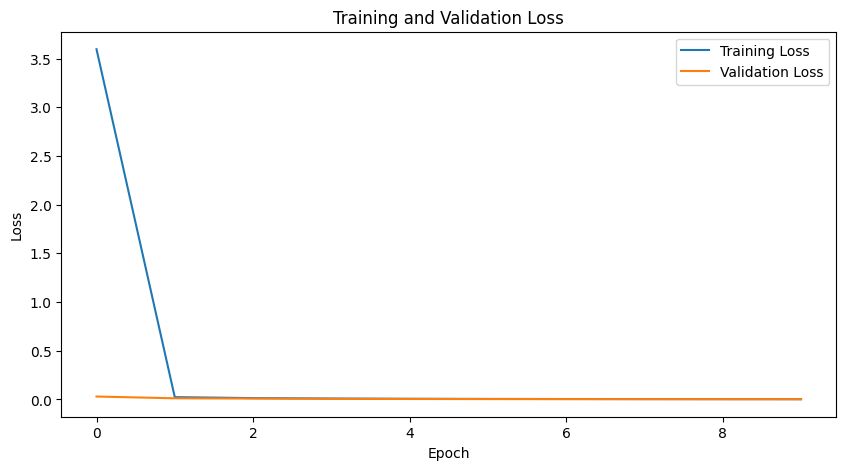

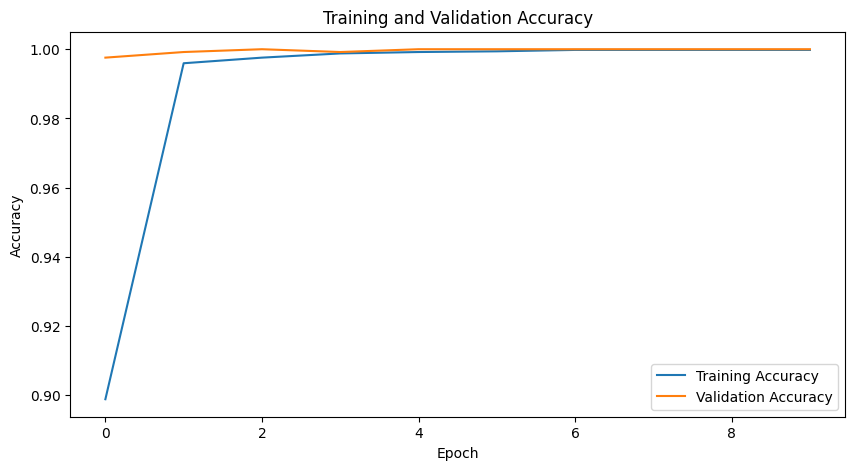

Epoch 1/10
----------


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]


train Loss: 2.4583 Acc: 0.9049


100%|██████████| 20/20 [00:02<00:00,  7.09it/s]


val Loss: 0.0262 Acc: 0.9919
Saving Best Model with Validation Accuracy:  0.9918962722852511
Epoch 2/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.30it/s]


train Loss: 0.0142 Acc: 0.9955


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


val Loss: 0.0092 Acc: 0.9984
Saving Best Model with Validation Accuracy:  0.9983792544570502
Epoch 3/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.74it/s]


train Loss: 0.0077 Acc: 0.9984


100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


val Loss: 0.0075 Acc: 0.9976
Epoch 4/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.27it/s]


train Loss: 0.0055 Acc: 0.9992


100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


val Loss: 0.0064 Acc: 0.9984
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.16it/s]


train Loss: 0.0039 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


val Loss: 0.0068 Acc: 0.9976
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.23it/s]


train Loss: 0.0033 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.34it/s]


val Loss: 0.0052 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991896272285251
Epoch 7/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.30it/s]


train Loss: 0.0027 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.26it/s]


val Loss: 0.0053 Acc: 0.9976
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.13it/s]


train Loss: 0.0023 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


val Loss: 0.0045 Acc: 0.9984
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.15it/s]


train Loss: 0.0020 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.11it/s]


val Loss: 0.0042 Acc: 0.9992
Epoch 10/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


val Loss: 0.0040 Acc: 0.9984
Training complete in 2m 16s
Best Validation Accuracy: 0.9992


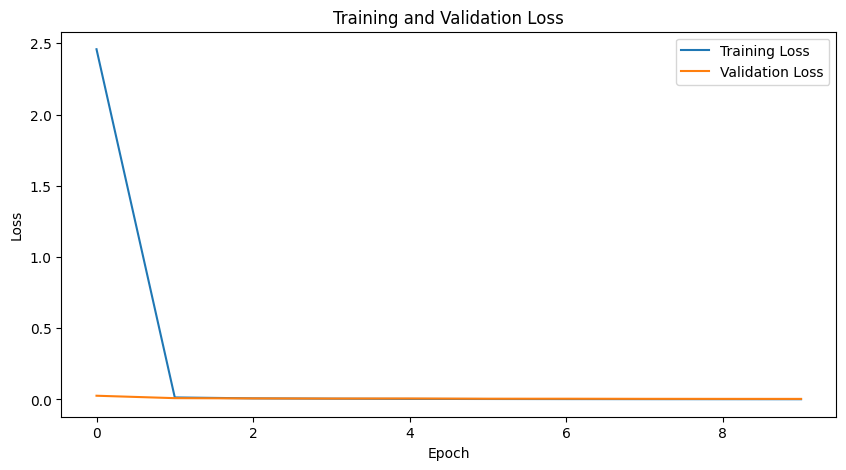

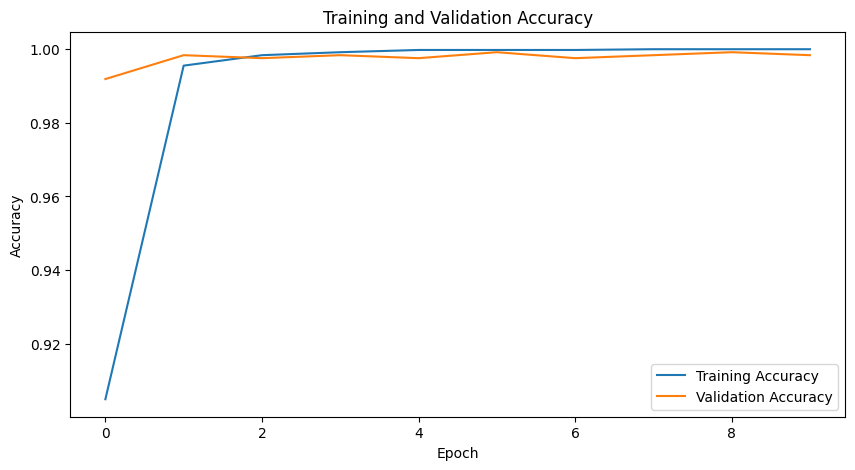

Epoch 1/10
----------


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]


train Loss: 2.3954 Acc: 0.9106


100%|██████████| 20/20 [00:02<00:00,  7.72it/s]


val Loss: 0.0203 Acc: 0.9943
Saving Best Model with Validation Accuracy:  0.9943273905996758
Epoch 2/10
----------


100%|██████████| 78/78 [00:11<00:00,  7.06it/s]


train Loss: 0.0132 Acc: 0.9961


100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


val Loss: 0.0096 Acc: 0.9984
Saving Best Model with Validation Accuracy:  0.9983792544570502
Epoch 3/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.11it/s]


train Loss: 0.0077 Acc: 0.9984


100%|██████████| 20/20 [00:02<00:00,  7.27it/s]


val Loss: 0.0063 Acc: 1.0000
Saving Best Model with Validation Accuracy:  1.0
Epoch 4/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.39it/s]


train Loss: 0.0049 Acc: 0.9996


100%|██████████| 20/20 [00:02<00:00,  7.40it/s]


val Loss: 0.0051 Acc: 1.0000
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.21it/s]


train Loss: 0.0036 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.28it/s]


val Loss: 0.0043 Acc: 1.0000
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.32it/s]


train Loss: 0.0030 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.39it/s]


val Loss: 0.0037 Acc: 1.0000
Epoch 7/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.27it/s]


train Loss: 0.0025 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


val Loss: 0.0033 Acc: 1.0000
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.19it/s]


train Loss: 0.0020 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.35it/s]


val Loss: 0.0030 Acc: 1.0000
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.10it/s]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.30it/s]


val Loss: 0.0028 Acc: 1.0000
Epoch 10/10
----------


100%|██████████| 78/78 [00:11<00:00,  7.00it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.12it/s]


val Loss: 0.0026 Acc: 1.0000
Training complete in 2m 16s
Best Validation Accuracy: 1.0000


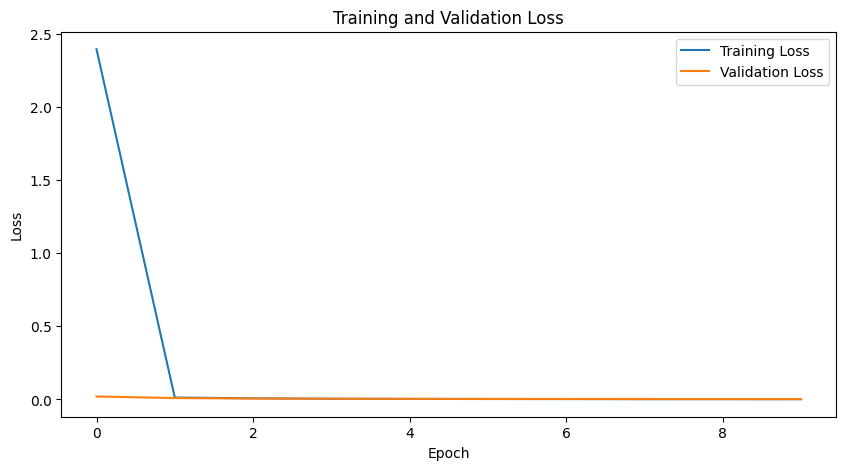

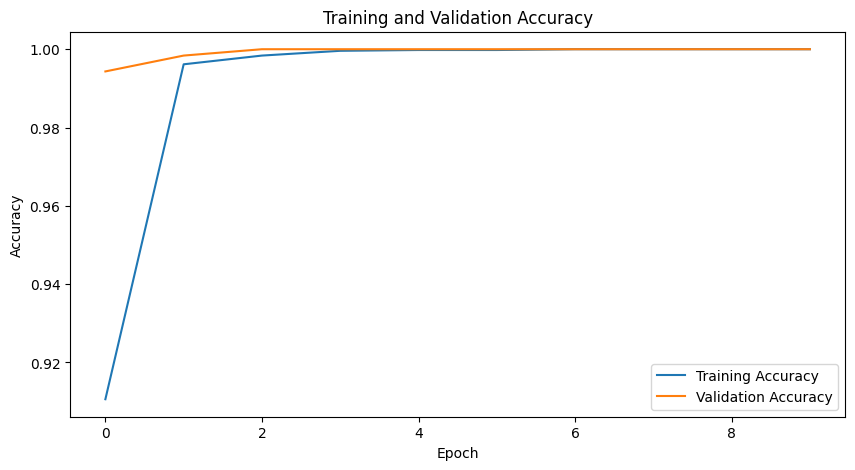

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_isic_lp_cl0_cl2_{seed}" + "train.pt"))

### Center Patch

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/original/train/class_0_half_first' #first half
#two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2'
zero_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/patches_center/train/class_0_half_second' #second half

#Test
test_two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
#dataset_two_cp = MnistDataset(path=two_cp_path, is_two=1, group_labels=[1] * len(os.listdir(two_cp_path)))
dataset_zero_cp = MnistDataset(path=zero_cp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_cp_path)))
dataset_test_two_cp = MnistDataset(path=test_two_cp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_cp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_cp, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_cp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 4933
num_val: 1234
num_test: 1032


Epoch 1/10
----------


100%|██████████| 78/78 [05:07<00:00,  3.94s/it]


train Loss: 3.6574 Acc: 0.8980


100%|██████████| 20/20 [01:19<00:00,  4.00s/it]


val Loss: 0.0366 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9975688816855753
Epoch 2/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.42it/s]


train Loss: 0.0291 Acc: 0.9943


100%|██████████| 20/20 [00:02<00:00,  7.41it/s]


val Loss: 0.0157 Acc: 0.9984
Saving Best Model with Validation Accuracy:  0.9983792544570502
Epoch 3/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.29it/s]


train Loss: 0.0165 Acc: 0.9968


100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


val Loss: 0.0127 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991896272285251
Epoch 4/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.27it/s]


train Loss: 0.0115 Acc: 0.9982


100%|██████████| 20/20 [00:02<00:00,  6.96it/s]


val Loss: 0.0080 Acc: 0.9992
Epoch 5/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.30it/s]


train Loss: 0.0084 Acc: 0.9990


100%|██████████| 20/20 [00:02<00:00,  7.07it/s]


val Loss: 0.0064 Acc: 0.9992
Epoch 6/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.63it/s]


train Loss: 0.0067 Acc: 0.9994


100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


val Loss: 0.0055 Acc: 0.9992
Epoch 7/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.43it/s]


train Loss: 0.0053 Acc: 0.9994


100%|██████████| 20/20 [00:02<00:00,  7.01it/s]


val Loss: 0.0052 Acc: 0.9992
Epoch 8/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.34it/s]


train Loss: 0.0044 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.21it/s]


val Loss: 0.0046 Acc: 0.9992
Epoch 9/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.67it/s]


train Loss: 0.0037 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


val Loss: 0.0041 Acc: 0.9992
Epoch 10/10
----------


100%|██████████| 78/78 [00:10<00:00,  7.33it/s]


train Loss: 0.0033 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  6.86it/s]


val Loss: 0.0037 Acc: 0.9992
Training complete in 8m 28s
Best Validation Accuracy: 0.9992


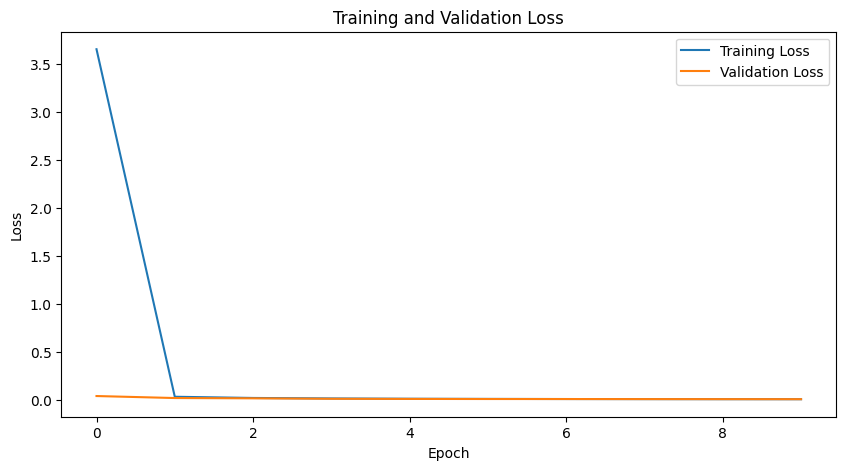

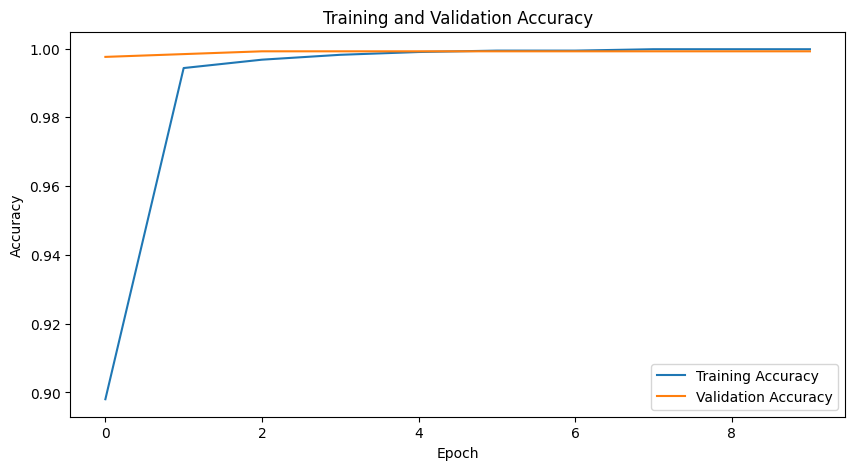

Epoch 1/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.98it/s]


train Loss: 2.3852 Acc: 0.9108


100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


val Loss: 0.0211 Acc: 0.9911
Saving Best Model with Validation Accuracy:  0.9910858995137762
Epoch 2/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.94it/s]


train Loss: 0.0140 Acc: 0.9968


100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


val Loss: 0.0107 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9975688816855753
Epoch 3/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.74it/s]


train Loss: 0.0080 Acc: 0.9982


100%|██████████| 20/20 [00:02<00:00,  7.29it/s]


val Loss: 0.0090 Acc: 0.9984
Saving Best Model with Validation Accuracy:  0.9983792544570502
Epoch 4/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.56it/s]


train Loss: 0.0056 Acc: 0.9996


100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


val Loss: 0.0068 Acc: 0.9984
Epoch 5/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.97it/s]


train Loss: 0.0042 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


val Loss: 0.0080 Acc: 0.9976
Epoch 6/10
----------


100%|██████████| 78/78 [00:11<00:00,  7.03it/s]


train Loss: 0.0036 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  6.96it/s]


val Loss: 0.0053 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991896272285251
Epoch 7/10
----------


100%|██████████| 78/78 [00:11<00:00,  7.01it/s]


train Loss: 0.0029 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.11it/s]


val Loss: 0.0055 Acc: 0.9992
Epoch 8/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.93it/s]


train Loss: 0.0024 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  7.30it/s]


val Loss: 0.0045 Acc: 0.9992
Epoch 9/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.79it/s]


train Loss: 0.0021 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  6.84it/s]


val Loss: 0.0042 Acc: 0.9992
Epoch 10/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.74it/s]


train Loss: 0.0018 Acc: 1.0000


100%|██████████| 20/20 [00:03<00:00,  6.65it/s]


val Loss: 0.0041 Acc: 0.9992
Training complete in 2m 22s
Best Validation Accuracy: 0.9992


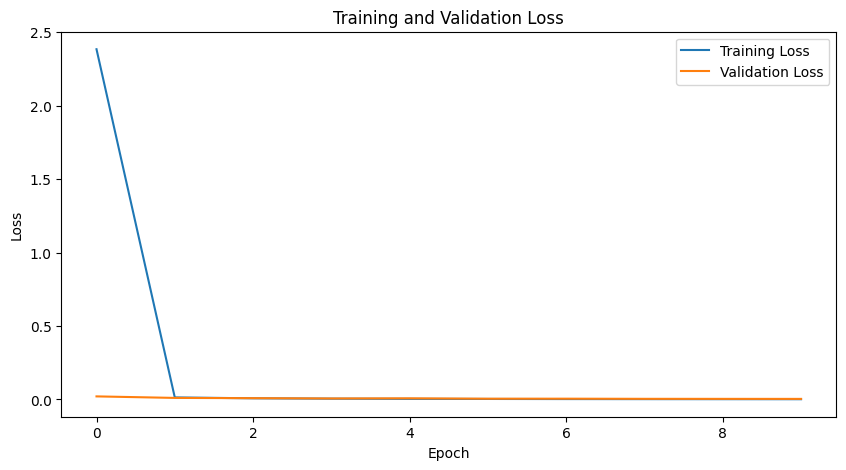

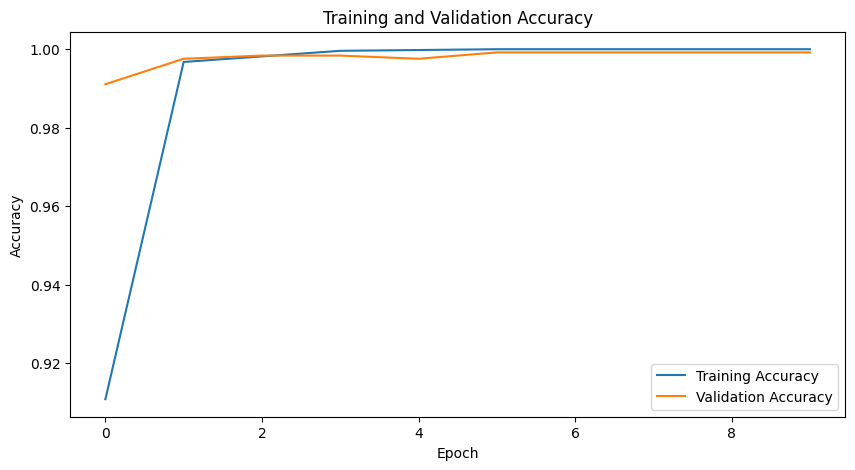

Epoch 1/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.87it/s]


train Loss: 2.4304 Acc: 0.9084


100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


val Loss: 0.0298 Acc: 0.9911
Saving Best Model with Validation Accuracy:  0.9910858995137762
Epoch 2/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.76it/s]


train Loss: 0.0139 Acc: 0.9961


100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


val Loss: 0.0109 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9975688816855753
Epoch 3/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.80it/s]


train Loss: 0.0072 Acc: 0.9988


100%|██████████| 20/20 [00:02<00:00,  6.75it/s]


val Loss: 0.0077 Acc: 0.9984
Saving Best Model with Validation Accuracy:  0.9983792544570502
Epoch 4/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.69it/s]


train Loss: 0.0049 Acc: 0.9998


100%|██████████| 20/20 [00:02<00:00,  7.05it/s]


val Loss: 0.0058 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991896272285251
Epoch 5/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.59it/s]


train Loss: 0.0036 Acc: 0.9998


100%|██████████| 20/20 [00:03<00:00,  6.62it/s]


val Loss: 0.0047 Acc: 0.9992
Epoch 6/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.50it/s]


train Loss: 0.0030 Acc: 0.9998


100%|██████████| 20/20 [00:03<00:00,  6.48it/s]


val Loss: 0.0042 Acc: 0.9992
Epoch 7/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.54it/s]


train Loss: 0.0025 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  6.91it/s]


val Loss: 0.0037 Acc: 1.0000
Saving Best Model with Validation Accuracy:  1.0
Epoch 8/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.80it/s]


train Loss: 0.0020 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  6.75it/s]


val Loss: 0.0034 Acc: 1.0000
Epoch 9/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.79it/s]


train Loss: 0.0018 Acc: 1.0000


100%|██████████| 20/20 [00:02<00:00,  6.72it/s]


val Loss: 0.0030 Acc: 1.0000
Epoch 10/10
----------


100%|██████████| 78/78 [00:11<00:00,  6.76it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


val Loss: 0.0028 Acc: 1.0000
Training complete in 2m 26s
Best Validation Accuracy: 1.0000


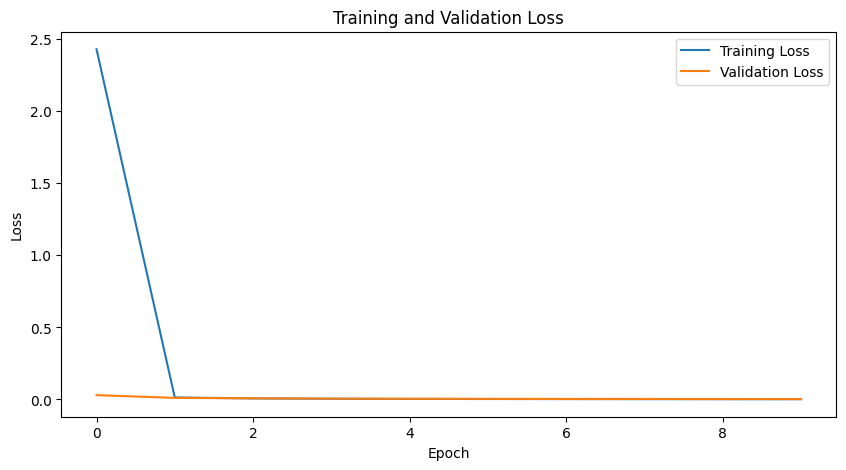

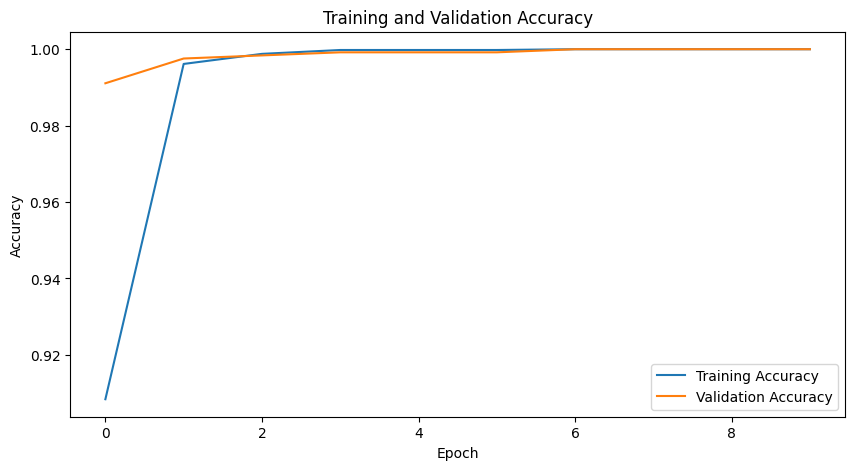

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_isic_cp_cl0_cl2_{seed}" + "train.pt"))

### Left vs. Center Patch

In [ ]:
#Train
#two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2_half_first'
zero_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/patches_center/train/class_0_half_second'
two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/patches_left/train/class_2'
zero_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits_isic/patches_left/train/class_0_half_first'

#Test
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'



# Create datasets for training and testing
#dataset_two_cp = MnistDataset(path=two_cp_path, is_two=1, group_labels=[0] * len(os.listdir(two_cp_path)))
dataset_zero_cp = MnistDataset(path=zero_cp_path, is_two=0, group_labels=[2] * len(os.listdir(zero_cp_path)))
dataset_two_lp = MnistDataset(path=two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(two_lp_path)))
dataset_zero_lp = MnistDataset(path=zero_lp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_lp_path)))
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_cp, dataset_zero_lp, dataset_two_lp))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_lp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 4847
num_val: 1212
num_test: 1032


Epoch 1/10
----------


100%|██████████| 76/76 [06:23<00:00,  5.04s/it]


train Loss: 3.9747 Acc: 0.8845


100%|██████████| 19/19 [01:33<00:00,  4.94s/it]


val Loss: 0.2877 Acc: 0.9134
Saving Best Model with Validation Accuracy:  0.9133663366336634
Epoch 2/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.85it/s]


train Loss: 0.2516 Acc: 0.9169


100%|██████████| 19/19 [00:02<00:00,  6.64it/s]


val Loss: 0.2633 Acc: 0.9134
Epoch 3/10
----------


100%|██████████| 76/76 [00:10<00:00,  7.56it/s]


train Loss: 0.2374 Acc: 0.9179


100%|██████████| 19/19 [00:01<00:00,  9.64it/s]


val Loss: 0.2541 Acc: 0.9142
Saving Best Model with Validation Accuracy:  0.9141914191419142
Epoch 4/10
----------


100%|██████████| 76/76 [00:08<00:00,  9.10it/s]


train Loss: 0.2221 Acc: 0.9173


100%|██████████| 19/19 [00:02<00:00,  6.55it/s]


val Loss: 0.2740 Acc: 0.9076
Epoch 5/10
----------


100%|██████████| 76/76 [00:10<00:00,  7.37it/s]


train Loss: 0.2176 Acc: 0.9164


100%|██████████| 19/19 [00:02<00:00,  6.55it/s]


val Loss: 0.2605 Acc: 0.9142
Epoch 6/10
----------


100%|██████████| 76/76 [00:10<00:00,  7.16it/s]


train Loss: 0.2114 Acc: 0.9171


100%|██████████| 19/19 [00:02<00:00,  6.48it/s]


val Loss: 0.2710 Acc: 0.9117
Epoch 7/10
----------


100%|██████████| 76/76 [00:10<00:00,  7.05it/s]


train Loss: 0.2088 Acc: 0.9175


100%|██████████| 19/19 [00:02<00:00,  6.41it/s]


val Loss: 0.2724 Acc: 0.9142
Epoch 8/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.89it/s]


train Loss: 0.2004 Acc: 0.9171


100%|██████████| 19/19 [00:03<00:00,  6.25it/s]


val Loss: 0.2705 Acc: 0.9109
Epoch 9/10
----------


100%|██████████| 76/76 [00:10<00:00,  7.05it/s]


train Loss: 0.1940 Acc: 0.9162


100%|██████████| 19/19 [00:02<00:00,  6.74it/s]


val Loss: 0.2832 Acc: 0.9142
Epoch 10/10
----------


100%|██████████| 76/76 [00:10<00:00,  7.08it/s]


train Loss: 0.1926 Acc: 0.9162


100%|██████████| 19/19 [00:02<00:00,  6.69it/s]


val Loss: 0.2791 Acc: 0.9117
Training complete in 9m 56s
Best Validation Accuracy: 0.9142


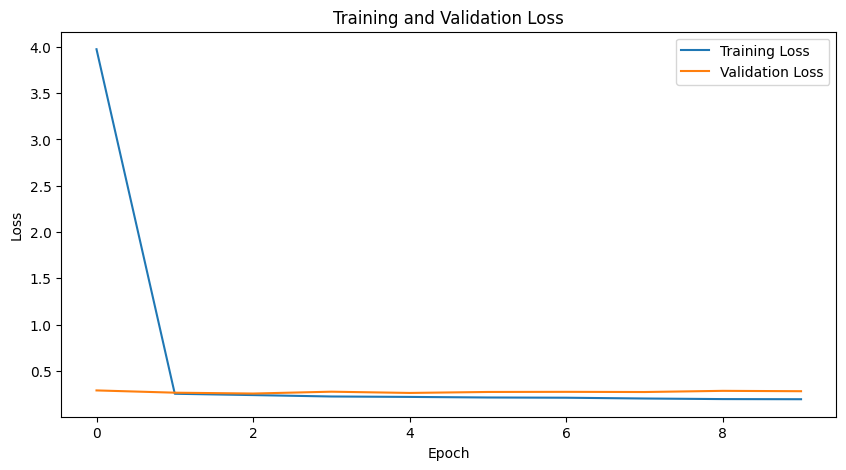

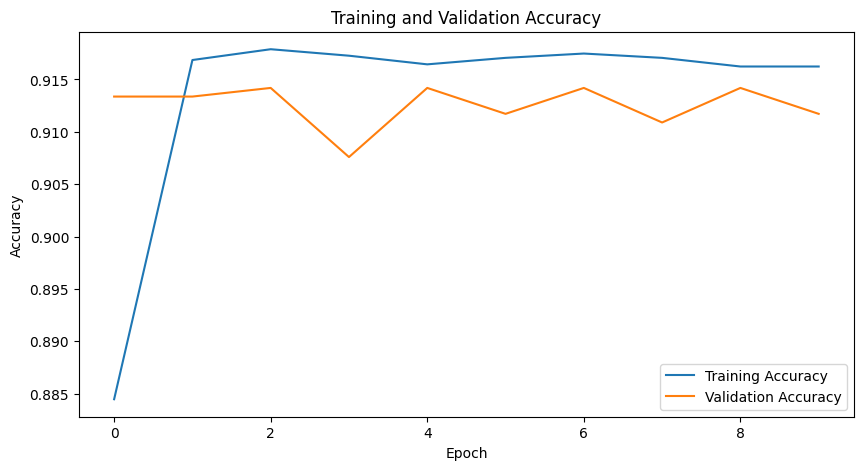

Epoch 1/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.82it/s]


train Loss: 2.5175 Acc: 0.8682


100%|██████████| 19/19 [00:02<00:00,  6.46it/s]


val Loss: 0.2813 Acc: 0.9142
Saving Best Model with Validation Accuracy:  0.9141914191419142
Epoch 2/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.75it/s]


train Loss: 0.2483 Acc: 0.9177


100%|██████████| 19/19 [00:02<00:00,  6.78it/s]


val Loss: 0.2543 Acc: 0.9142
Epoch 3/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.57it/s]


train Loss: 0.2349 Acc: 0.9171


100%|██████████| 19/19 [00:02<00:00,  6.80it/s]


val Loss: 0.2608 Acc: 0.9134
Epoch 4/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.68it/s]


train Loss: 0.2293 Acc: 0.9187


100%|██████████| 19/19 [00:02<00:00,  6.57it/s]


val Loss: 0.2580 Acc: 0.9125
Epoch 5/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.86it/s]


train Loss: 0.2181 Acc: 0.9166


100%|██████████| 19/19 [00:02<00:00,  6.84it/s]


val Loss: 0.2589 Acc: 0.9134
Epoch 6/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.72it/s]


train Loss: 0.2123 Acc: 0.9175


100%|██████████| 19/19 [00:02<00:00,  6.80it/s]


val Loss: 0.2612 Acc: 0.9117
Epoch 7/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.85it/s]


train Loss: 0.2069 Acc: 0.9166


100%|██████████| 19/19 [00:02<00:00,  6.49it/s]


val Loss: 0.2661 Acc: 0.9125
Epoch 8/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.69it/s]


train Loss: 0.1993 Acc: 0.9189


100%|██████████| 19/19 [00:02<00:00,  6.69it/s]


val Loss: 0.2747 Acc: 0.9134
Epoch 9/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.59it/s]


train Loss: 0.1921 Acc: 0.9166


100%|██████████| 19/19 [00:02<00:00,  6.41it/s]


val Loss: 0.2772 Acc: 0.9092
Epoch 10/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.72it/s]


train Loss: 0.1889 Acc: 0.9175


100%|██████████| 19/19 [00:02<00:00,  6.54it/s]


val Loss: 0.2930 Acc: 0.9092
Training complete in 2m 22s
Best Validation Accuracy: 0.9142


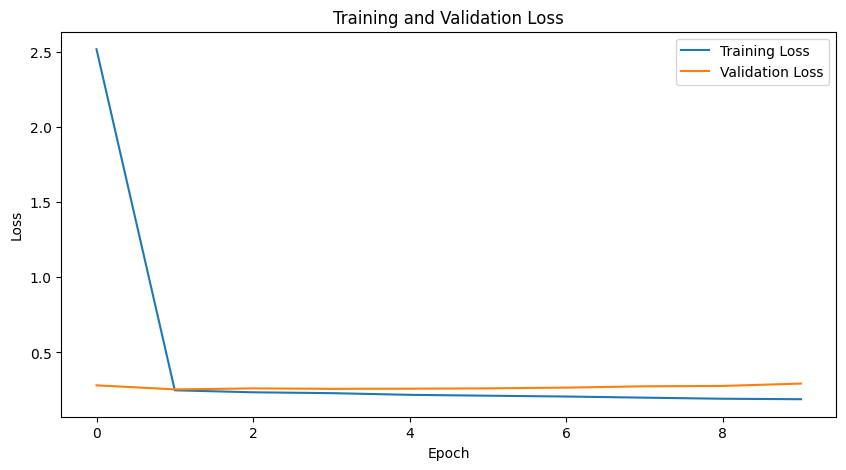

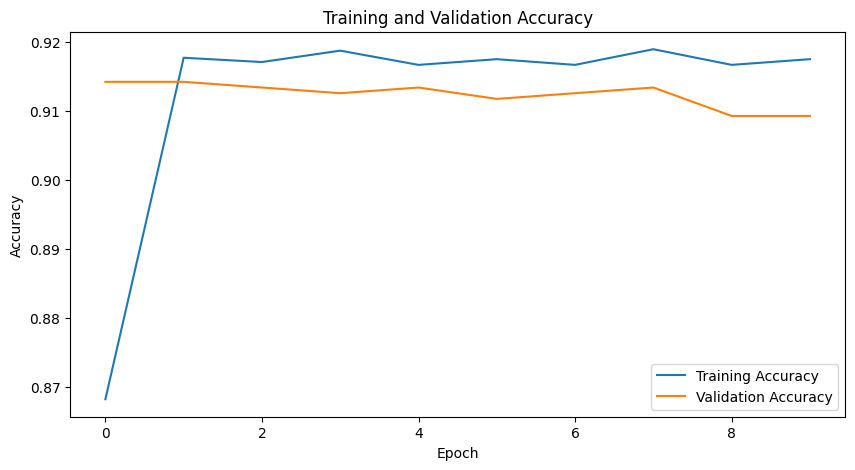

Epoch 1/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.68it/s]


train Loss: 2.7424 Acc: 0.8754


100%|██████████| 19/19 [00:03<00:00,  6.31it/s]


val Loss: 0.2714 Acc: 0.9142
Saving Best Model with Validation Accuracy:  0.9141914191419142
Epoch 2/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.83it/s]


train Loss: 0.2543 Acc: 0.9175


100%|██████████| 19/19 [00:02<00:00,  6.40it/s]


val Loss: 0.2737 Acc: 0.9142
Epoch 3/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.45it/s]


train Loss: 0.2366 Acc: 0.9185


100%|██████████| 19/19 [00:02<00:00,  6.50it/s]


val Loss: 0.3093 Acc: 0.8845
Epoch 4/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.55it/s]


train Loss: 0.2537 Acc: 0.9156


100%|██████████| 19/19 [00:03<00:00,  6.26it/s]


val Loss: 0.2761 Acc: 0.9142
Epoch 5/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.62it/s]


train Loss: 0.2334 Acc: 0.9177


100%|██████████| 19/19 [00:02<00:00,  6.77it/s]


val Loss: 0.2723 Acc: 0.9142
Epoch 6/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.69it/s]


train Loss: 0.2204 Acc: 0.9160


100%|██████████| 19/19 [00:02<00:00,  6.70it/s]


val Loss: 0.2732 Acc: 0.9142
Epoch 7/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.64it/s]


train Loss: 0.2115 Acc: 0.9175


100%|██████████| 19/19 [00:02<00:00,  6.83it/s]


val Loss: 0.2860 Acc: 0.9043
Epoch 8/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.68it/s]


train Loss: 0.2125 Acc: 0.9162


100%|██████████| 19/19 [00:02<00:00,  6.57it/s]


val Loss: 0.2704 Acc: 0.9092
Epoch 9/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.67it/s]


train Loss: 0.2056 Acc: 0.9169


100%|██████████| 19/19 [00:02<00:00,  6.63it/s]


val Loss: 0.3025 Acc: 0.8828
Epoch 10/10
----------


100%|██████████| 76/76 [00:11<00:00,  6.65it/s]


train Loss: 0.1981 Acc: 0.9162


100%|██████████| 19/19 [00:02<00:00,  6.58it/s]


val Loss: 0.2794 Acc: 0.9059
Training complete in 2m 24s
Best Validation Accuracy: 0.9142


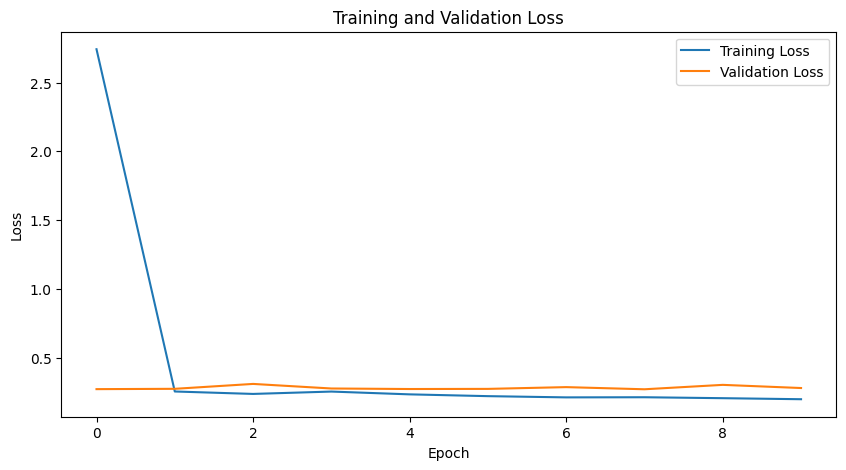

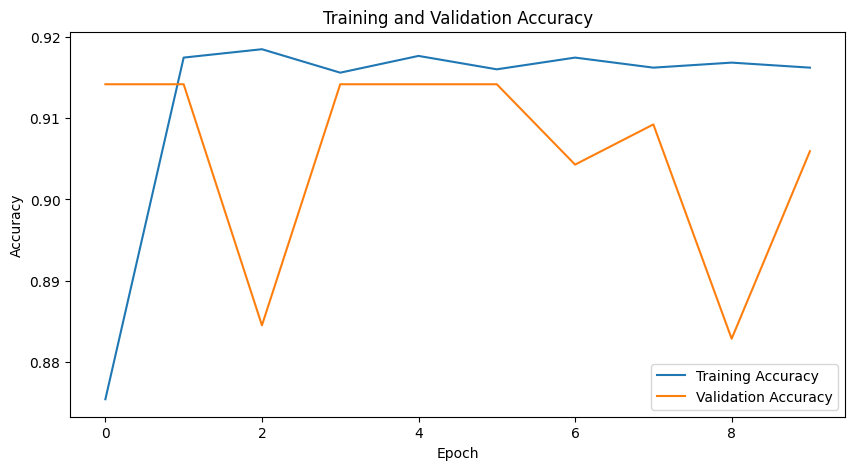

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_isic_cp_lp_cl0_cl2_{seed}" + "train.pt"))

## Activation extraction

### Original vs. Colored BG

#### Correlation

Computing activations and saving to activations.npy


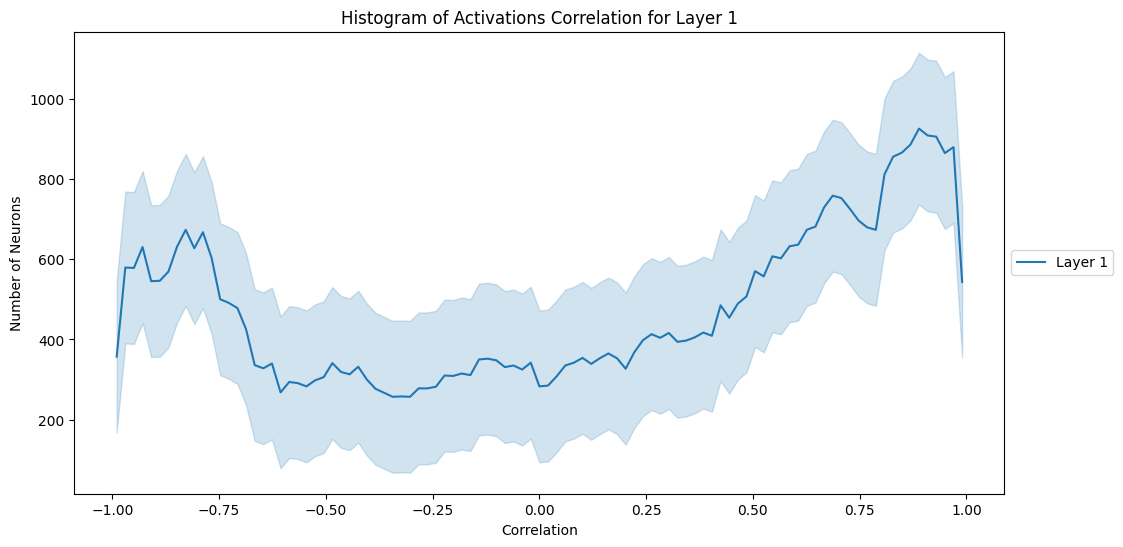

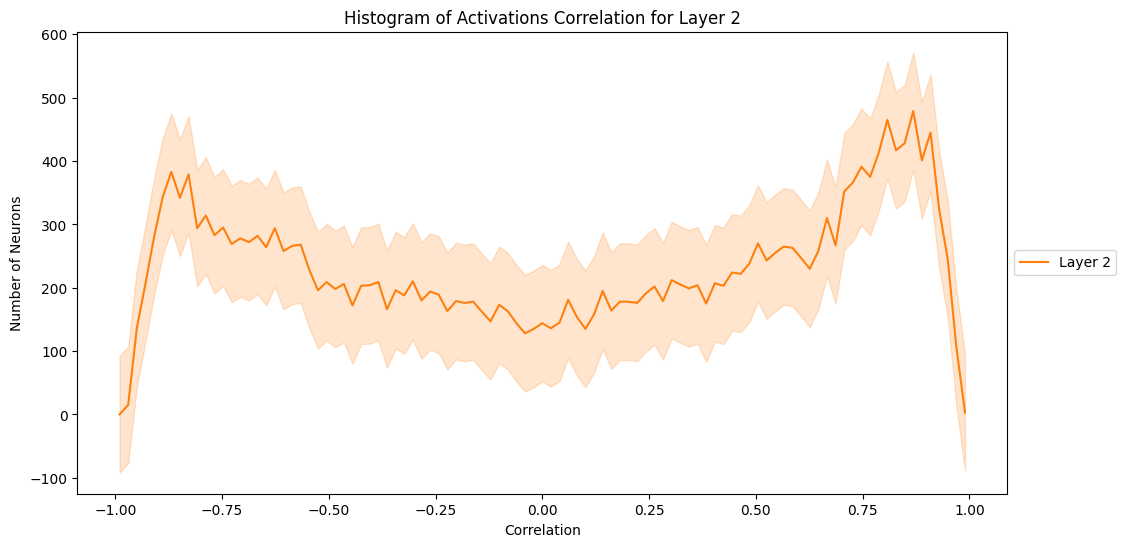

<ipython-input-23-c3d99e636236>:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


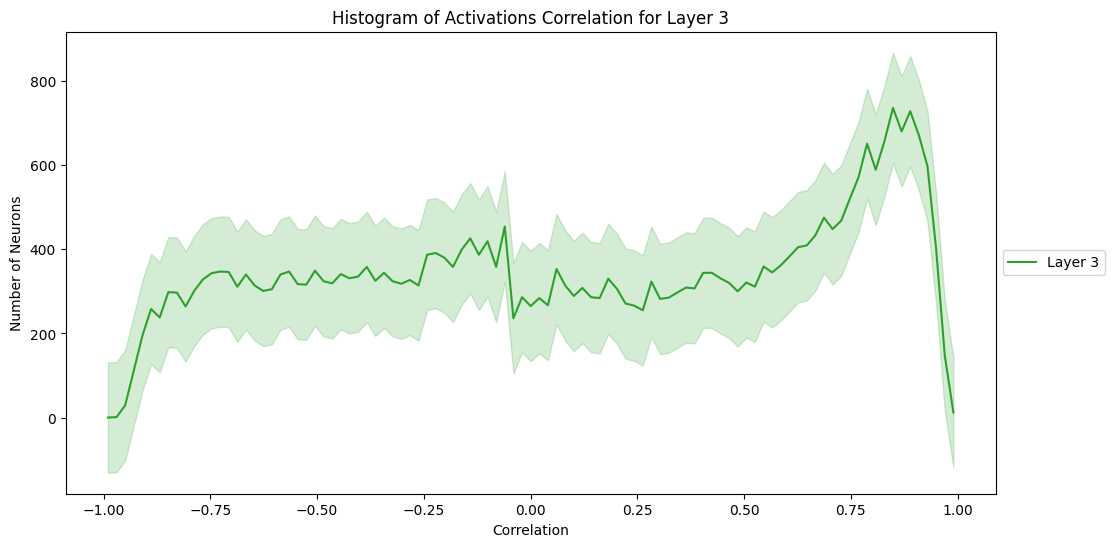

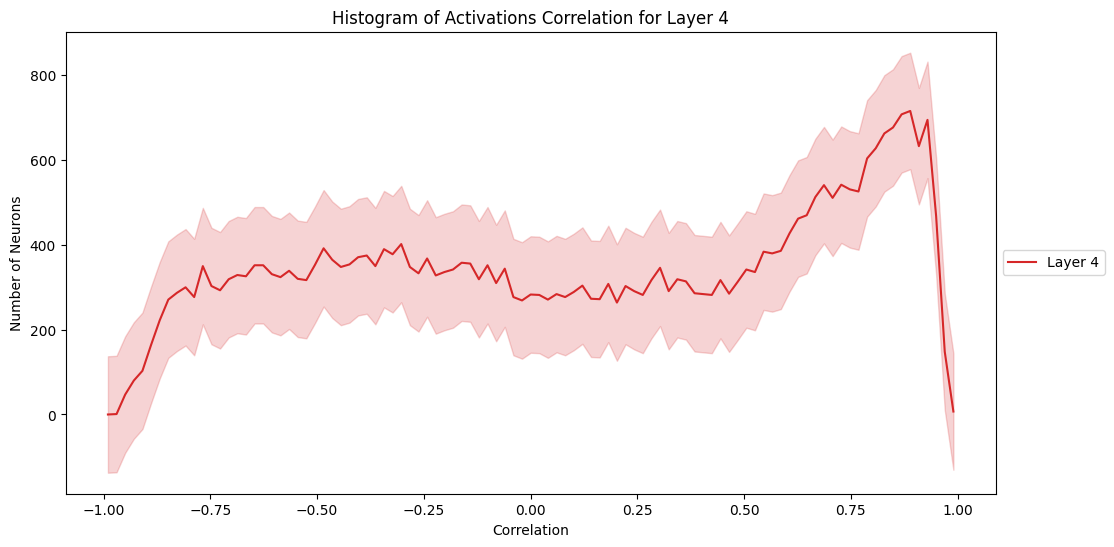

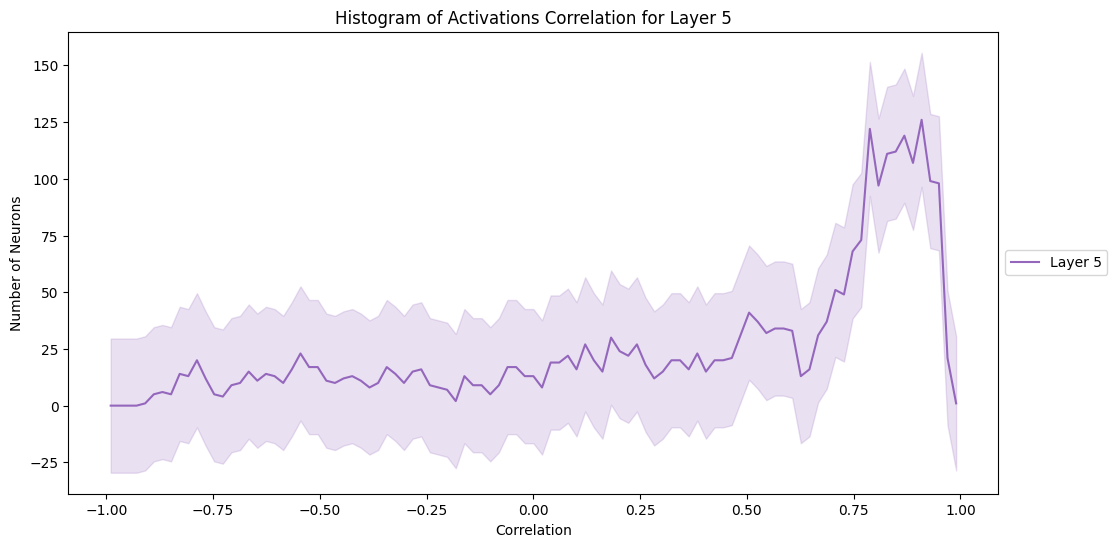

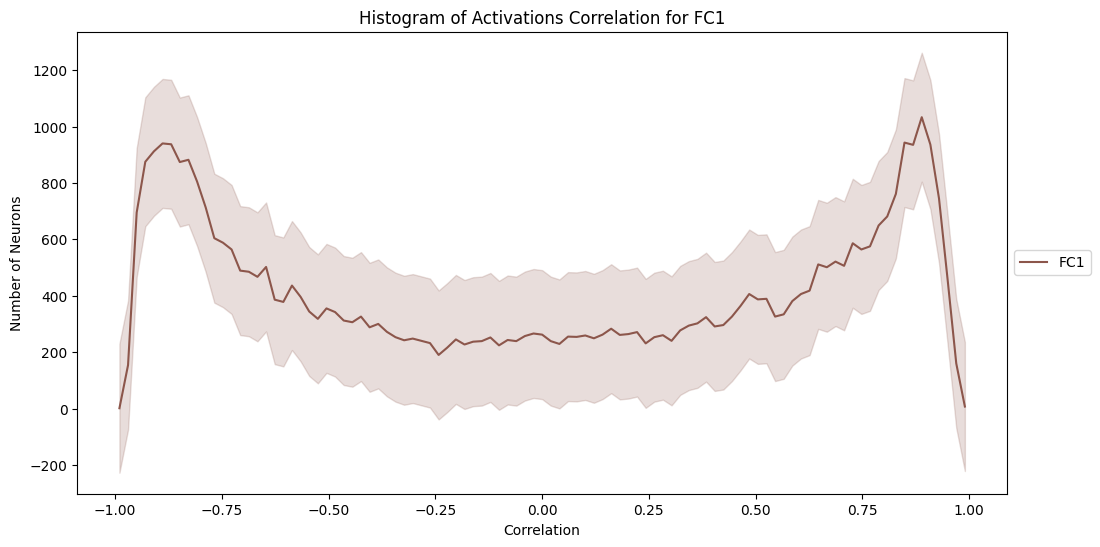

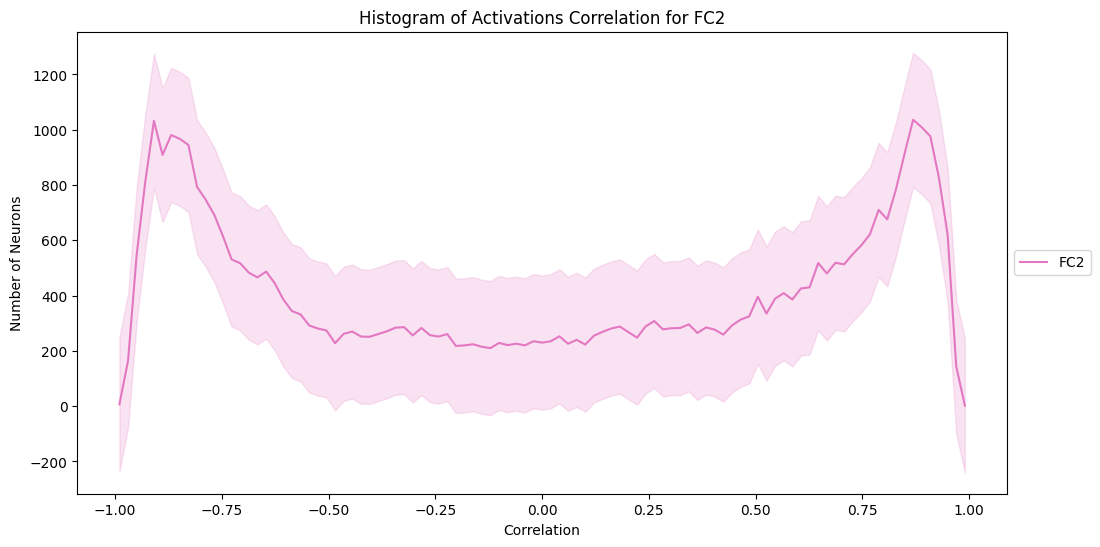

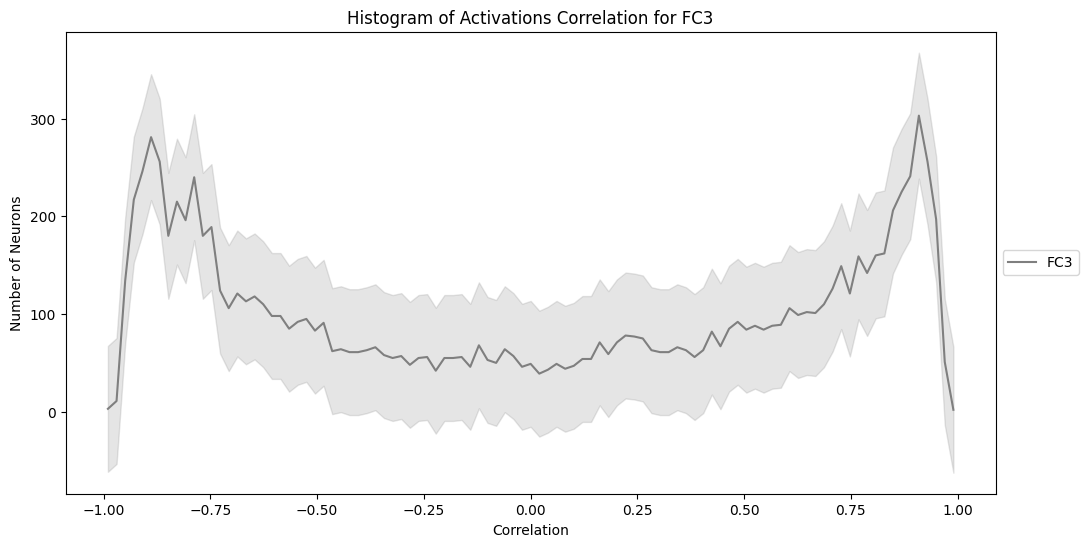

<ipython-input-23-c3d99e636236>:228: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


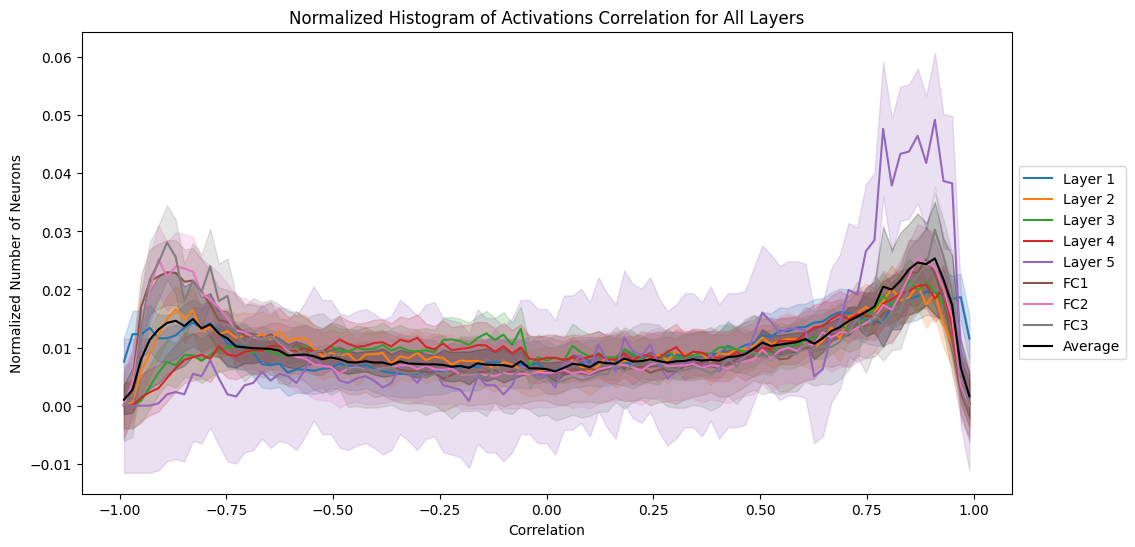

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations


def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/background/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('background', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'background', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

bg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_bg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_bg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_bg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, bg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 2.1926
  WO Activations:
    Mean: 1.9146
  T-Test:
    T-statistic: 1.6176
    P-value: 0.0491
    Percentage of neurons with p-value <= 0.05: 87.75%
    Percentage of neurons with p-value <= 0.02: 85.20%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.9471
  WO Activations:
    Mean: 1.7775
  T-Test:
    T-statistic: 0.5442
    P-value: 0.0757
    Percentage of neurons with p-value <= 0.05: 81.07%
    Percentage of neurons with p-value <= 0.02: 77.55%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.7509
  WO Activations:
    Mean: 0.5877
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 80.12%
    Percentage of neurons with p-value <= 0.02: 76.60%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.4308
  WO Activations:
    Mean: 0.3117
  T-Test:
    T-statistic: nan
    P-value: n

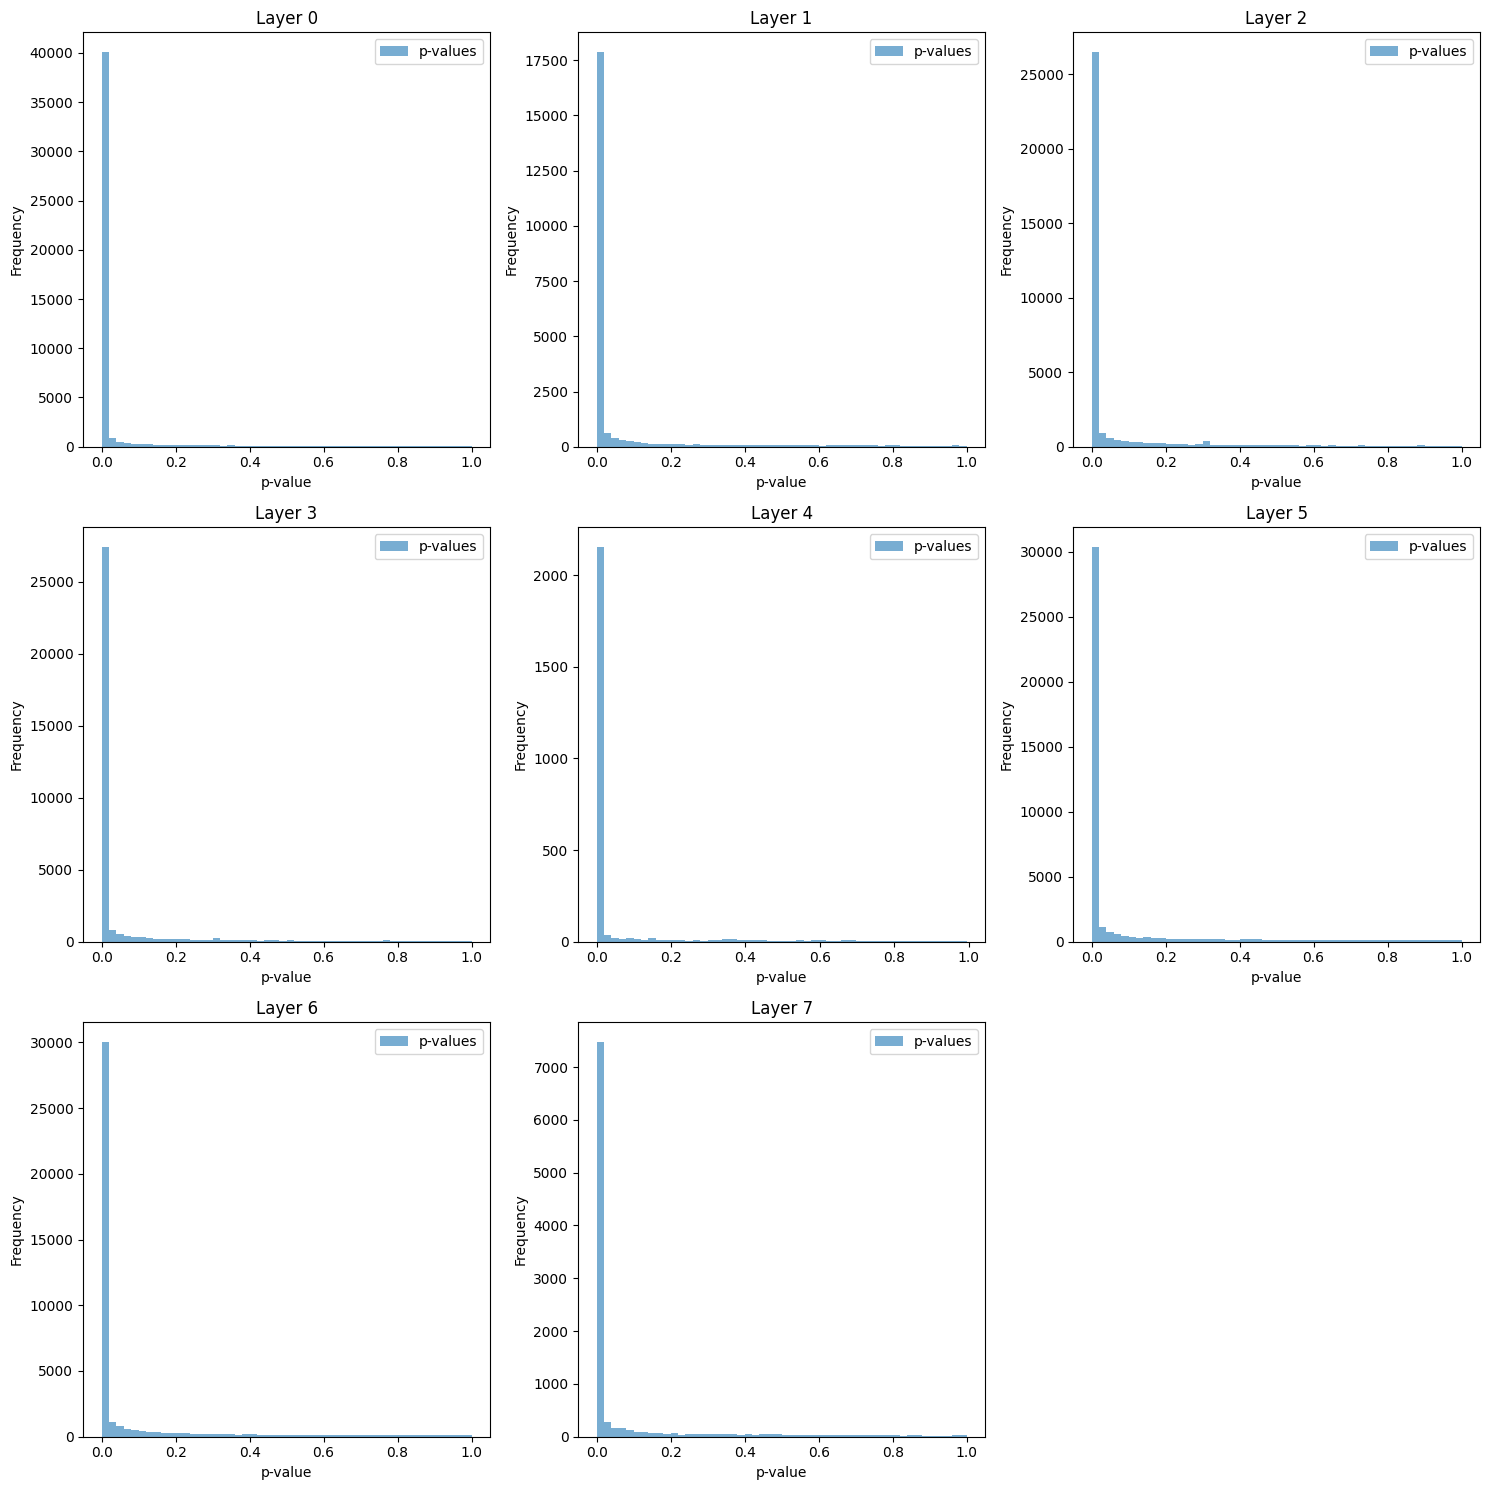

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both background and original conditions
background_activations = {layer: load_activations('background', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(background_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Original vs. colored Digit

#### Correlations

Computing activations and saving to activations.npy


<ipython-input-25-a38363dde984>:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


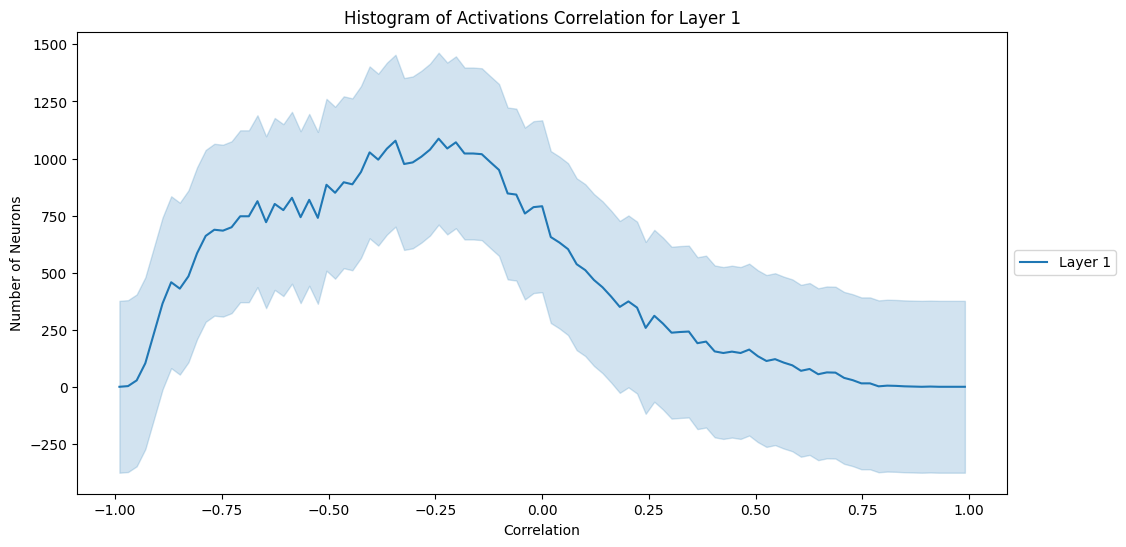

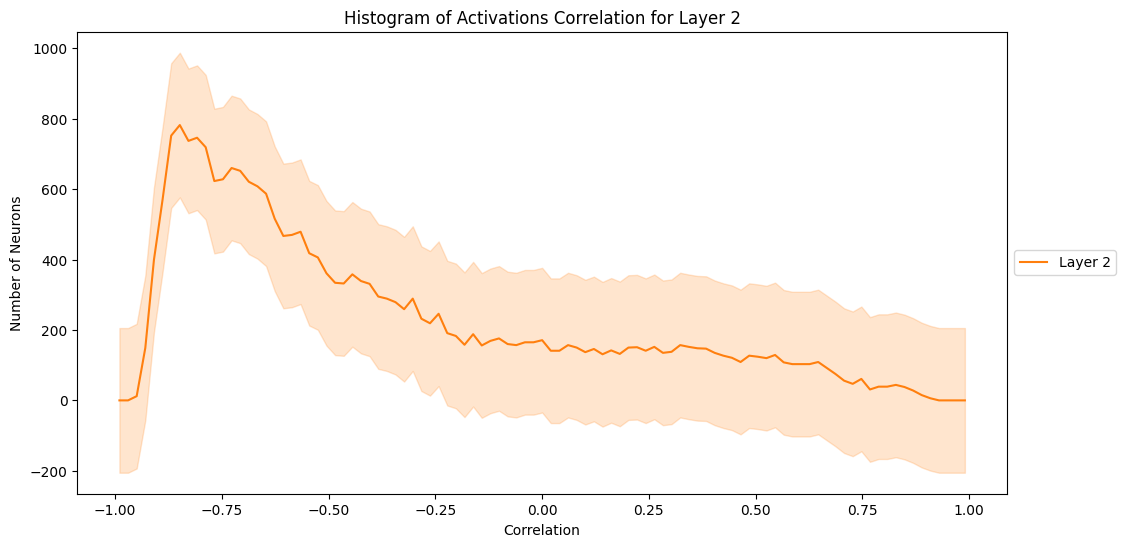

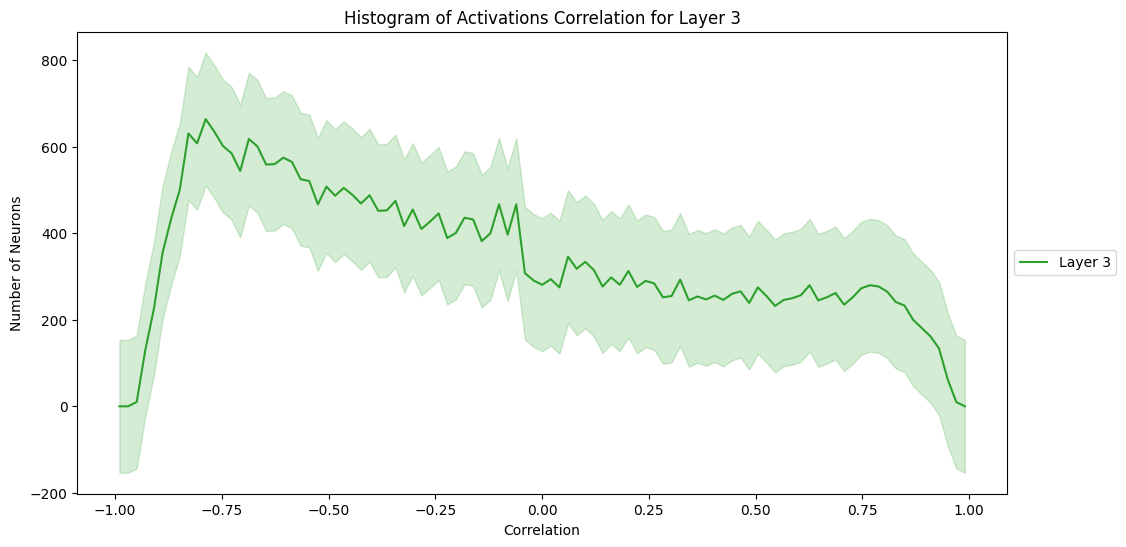

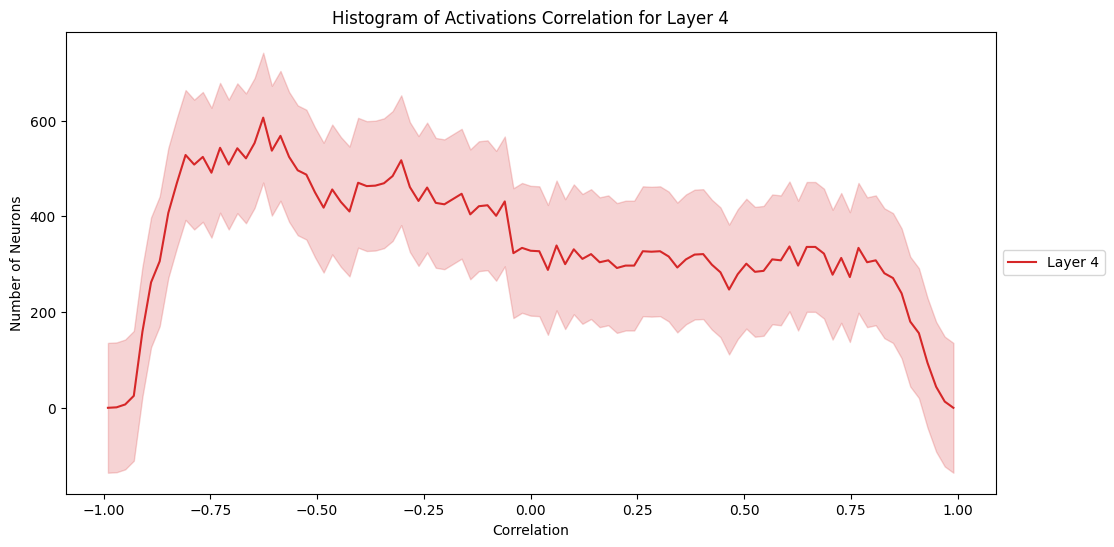

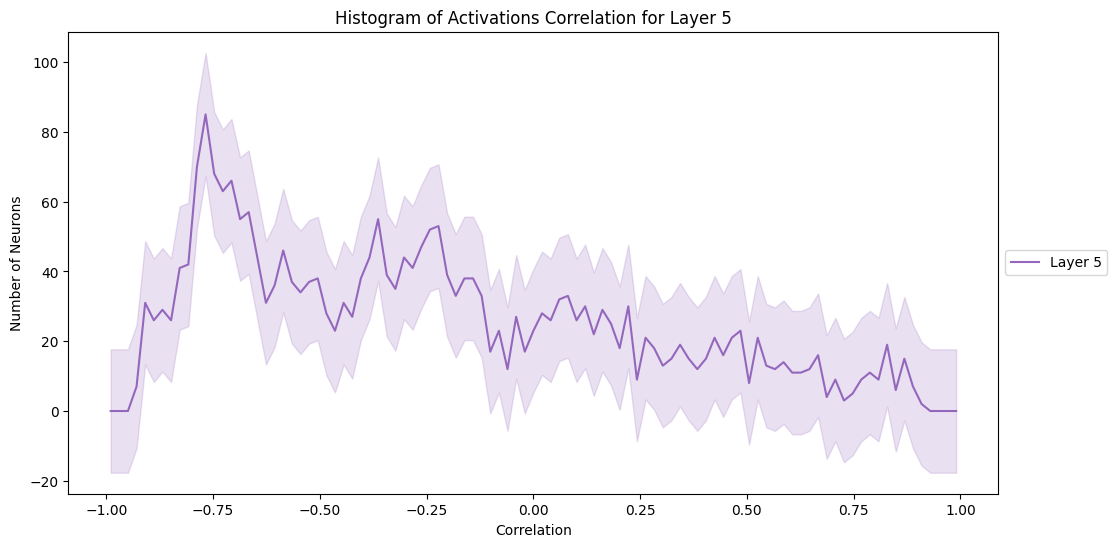

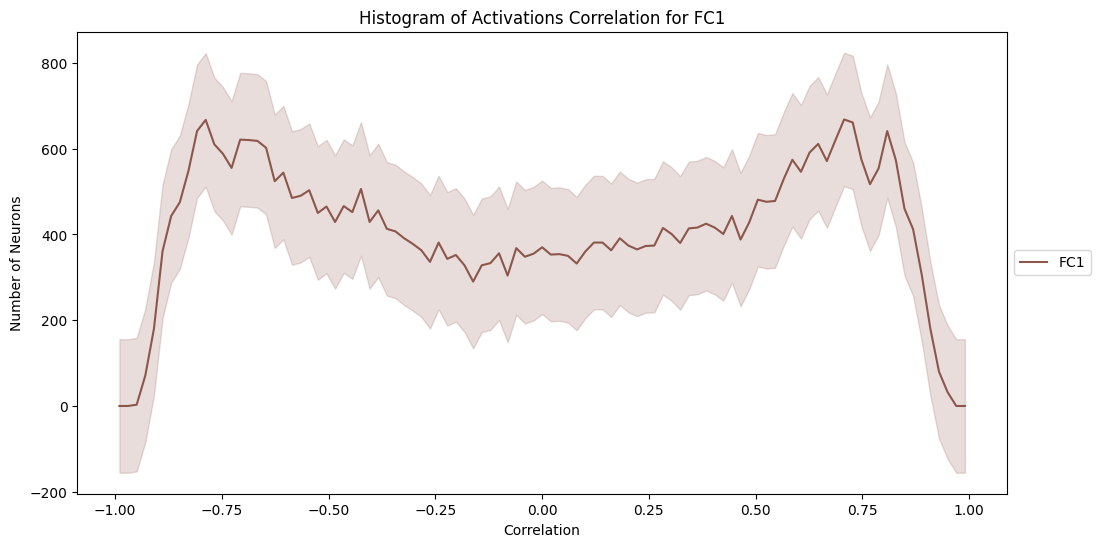

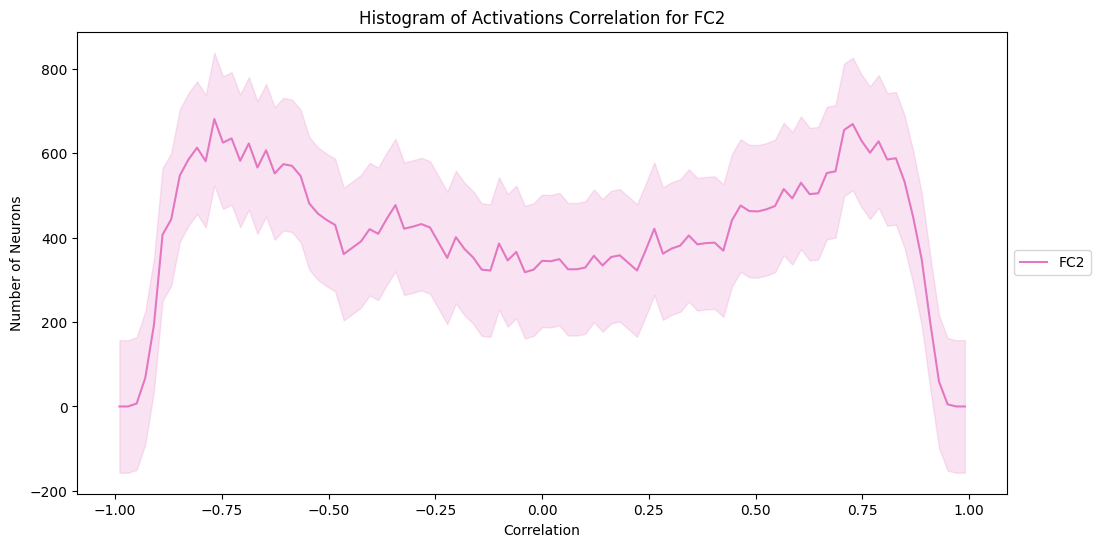

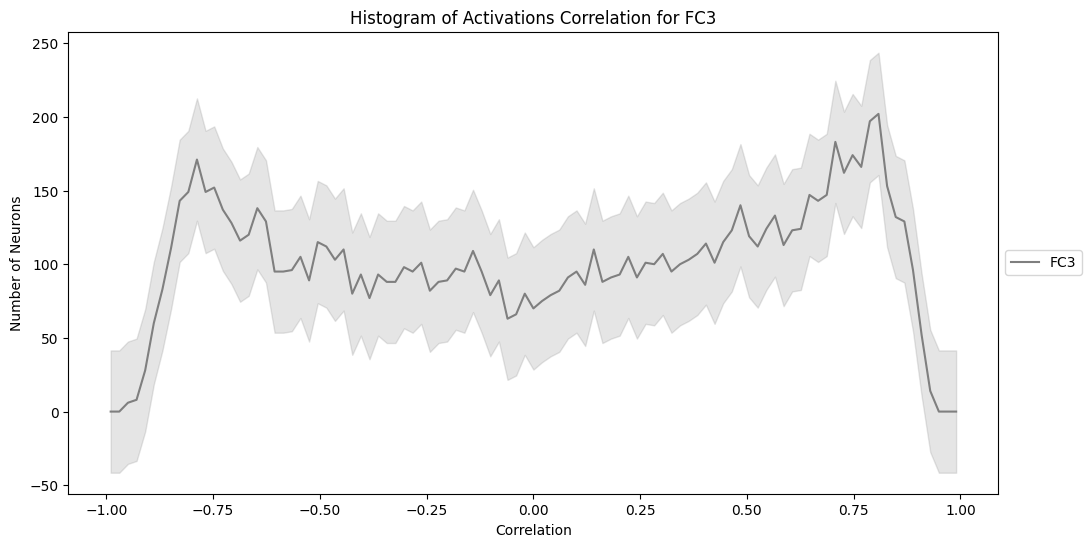

<ipython-input-25-a38363dde984>:229: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


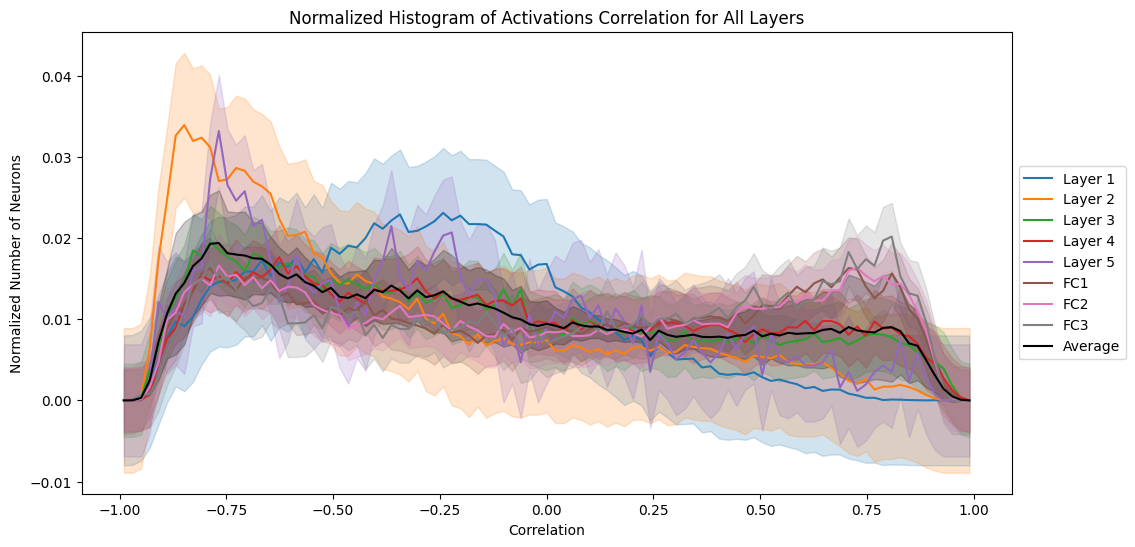

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/foreground/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('foreground', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'foreground', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

fg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_fg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_fg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_fg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, fg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


####Two sample t-test

Layer 0:
  WP Activations:
    Mean: 1.4008
  WO Activations:
    Mean: 1.9079
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 69.70%
    Percentage of neurons with p-value <= 0.02: 65.49%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.4081
  WO Activations:
    Mean: 1.9924
  T-Test:
    T-statistic: -5.0486
    P-value: 0.0754
    Percentage of neurons with p-value <= 0.05: 81.21%
    Percentage of neurons with p-value <= 0.02: 77.22%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5801
  WO Activations:
    Mean: 0.7569
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 77.65%
    Percentage of neurons with p-value <= 0.02: 73.55%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.3559
  WO Activations:
    Mean: 0.4346
  T-Test:
    T-statistic: nan
    P-value: nan
  

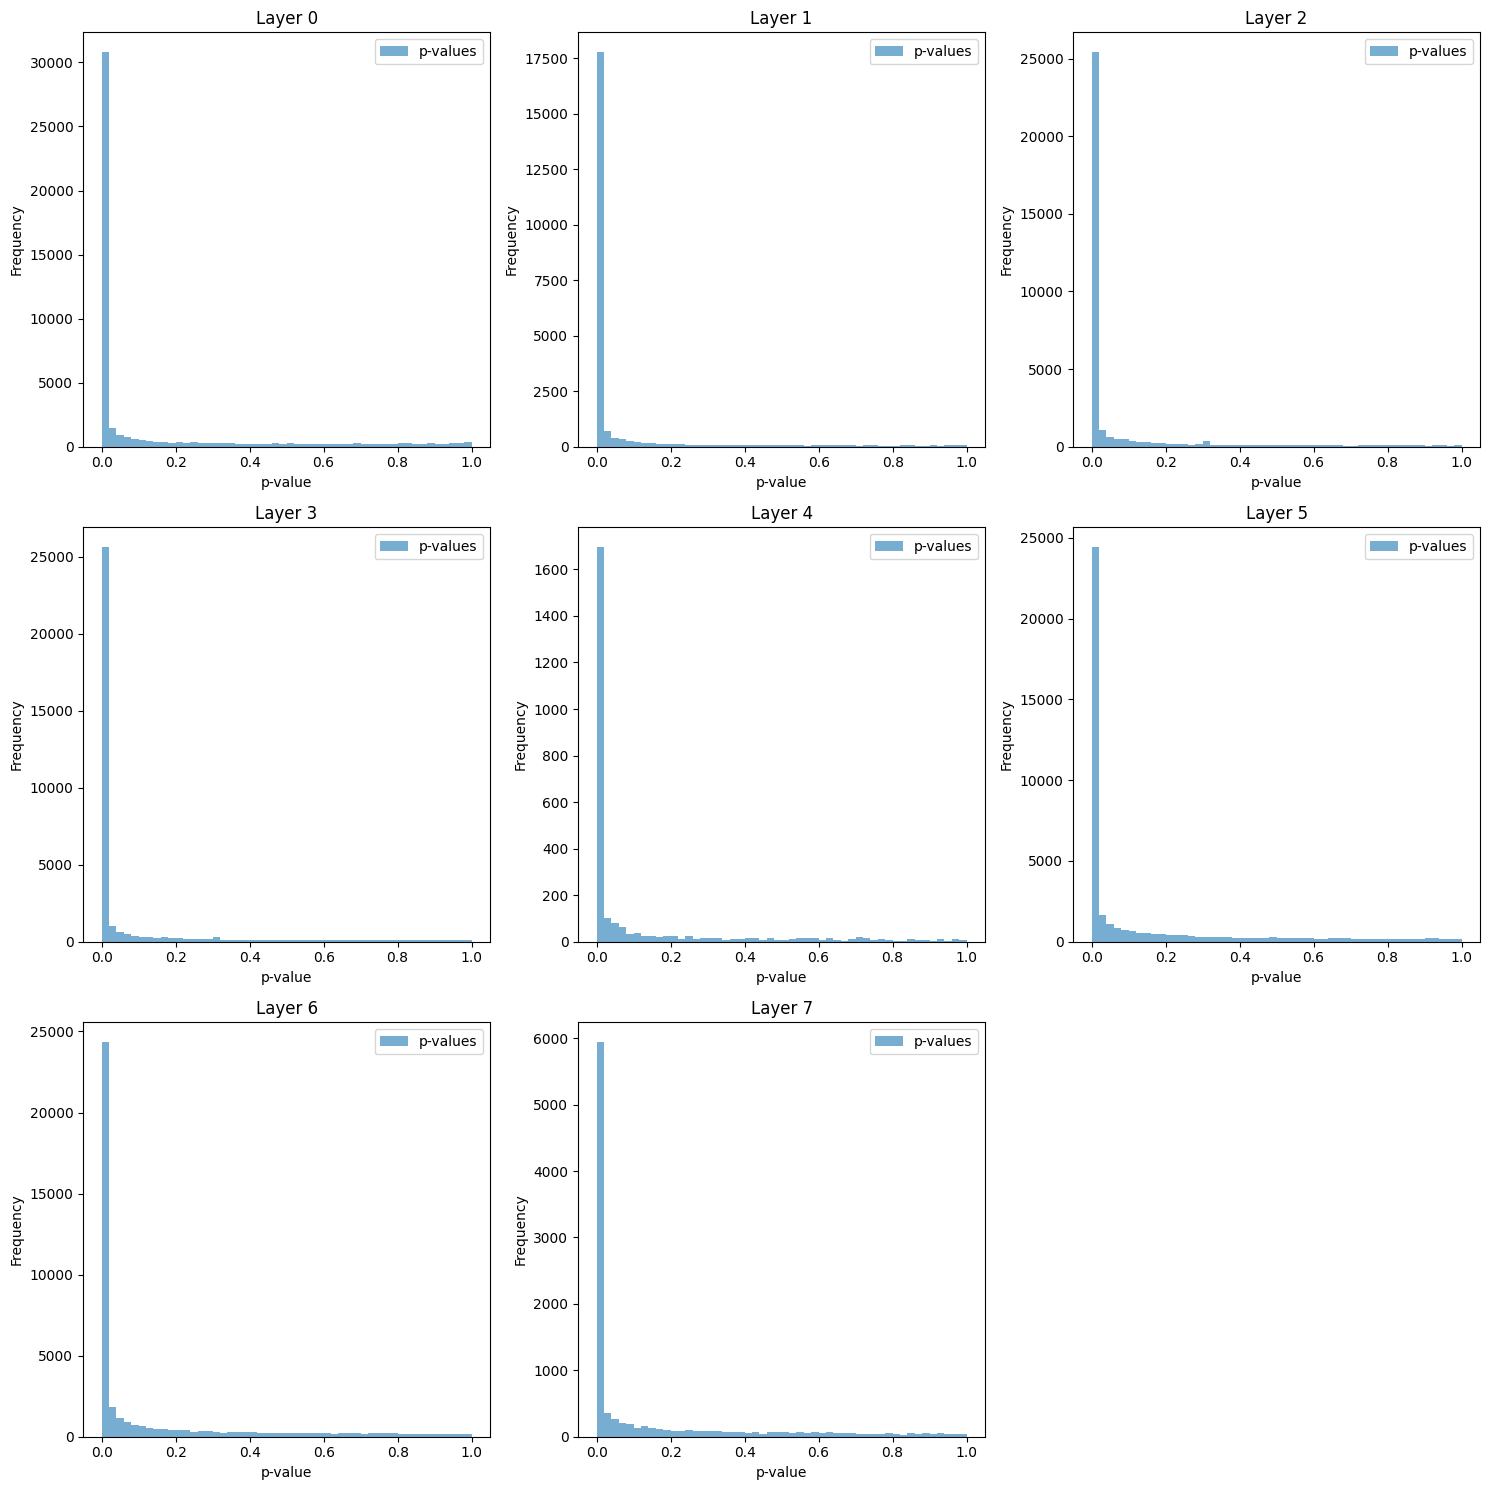

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both foreground and original conditions
foreground_activations = {layer: load_activations('foreground', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(foreground_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Original vs. left patch

#### Correlations

Computing activations and saving to activations.npy


<ipython-input-27-5587268dd0cb>:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


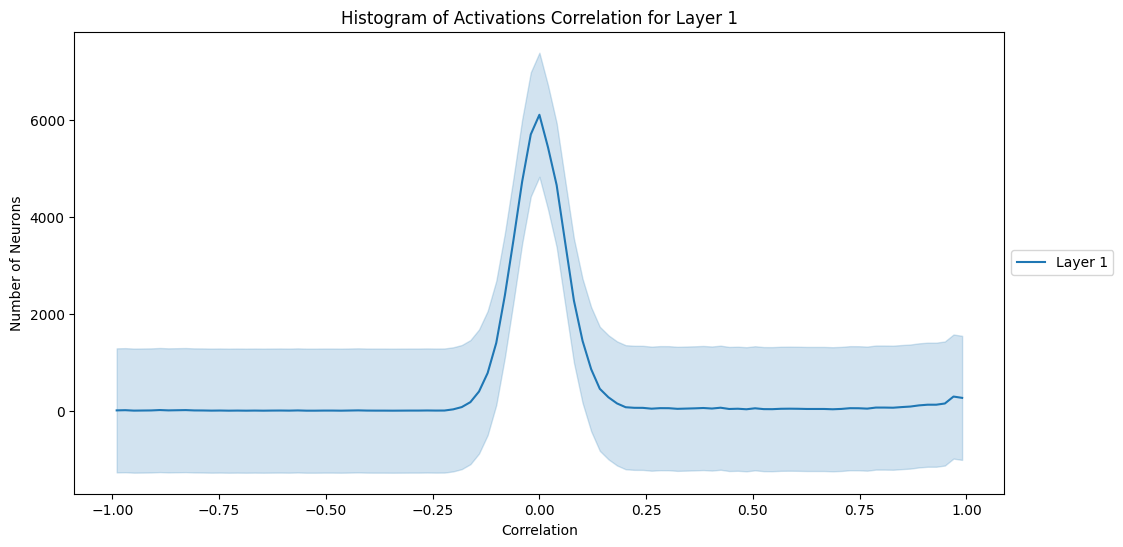

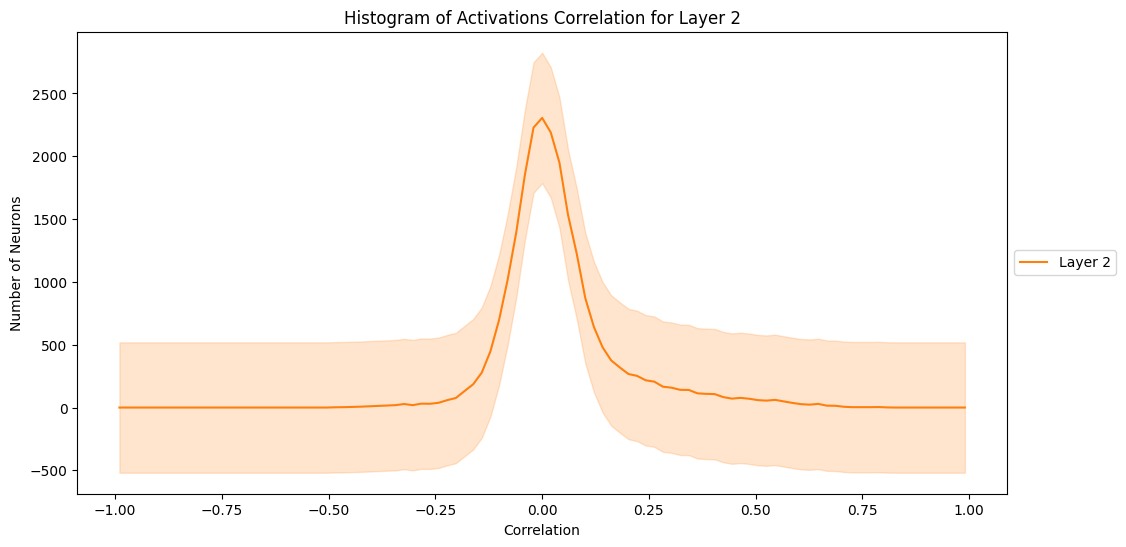

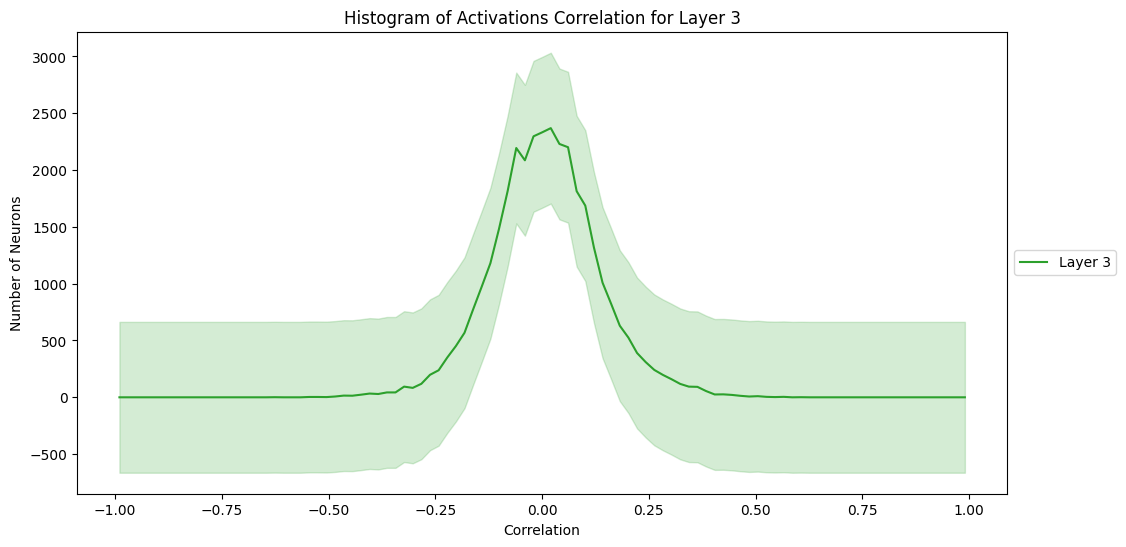

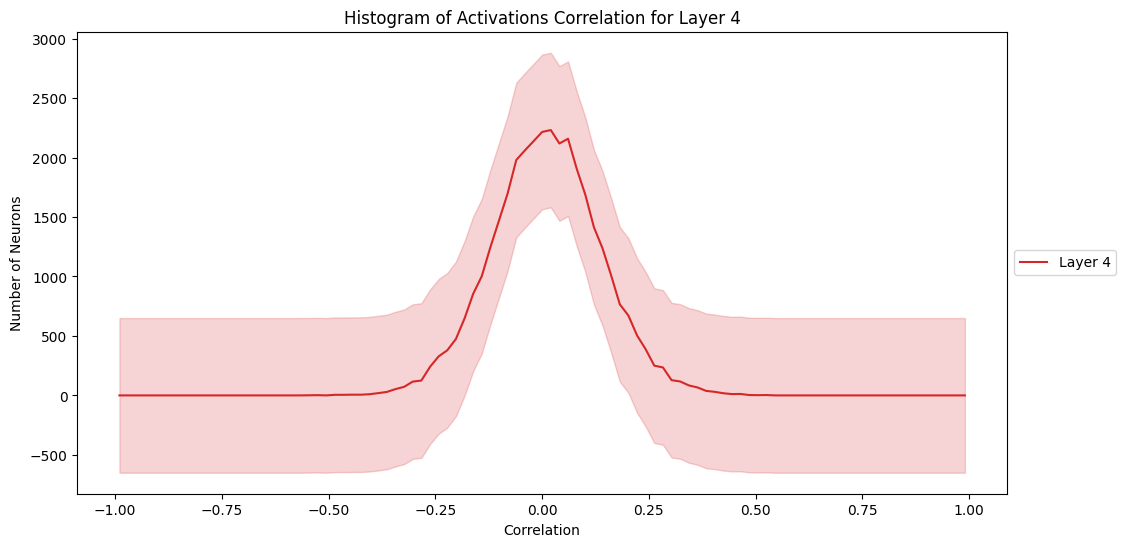

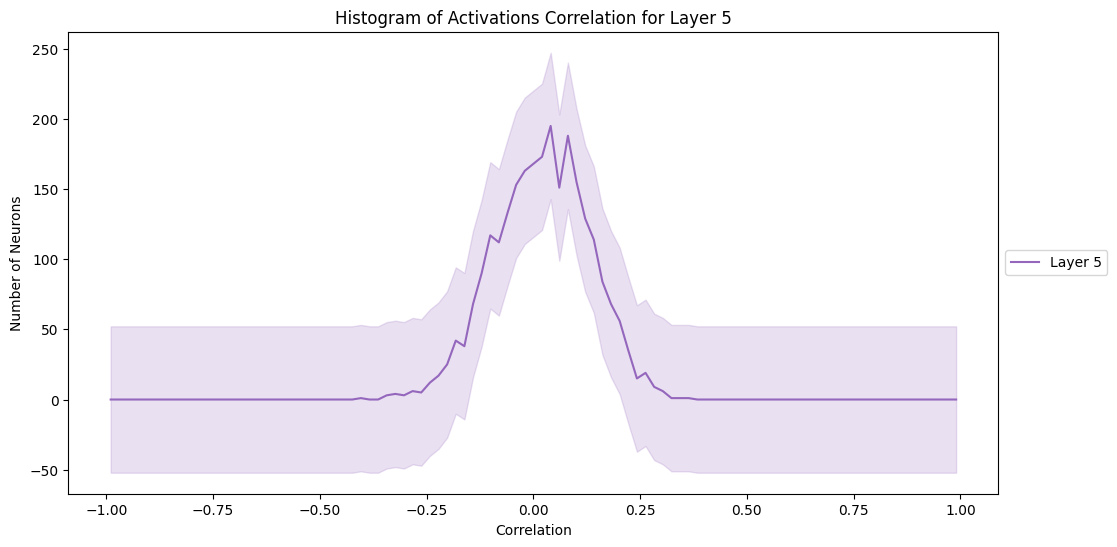

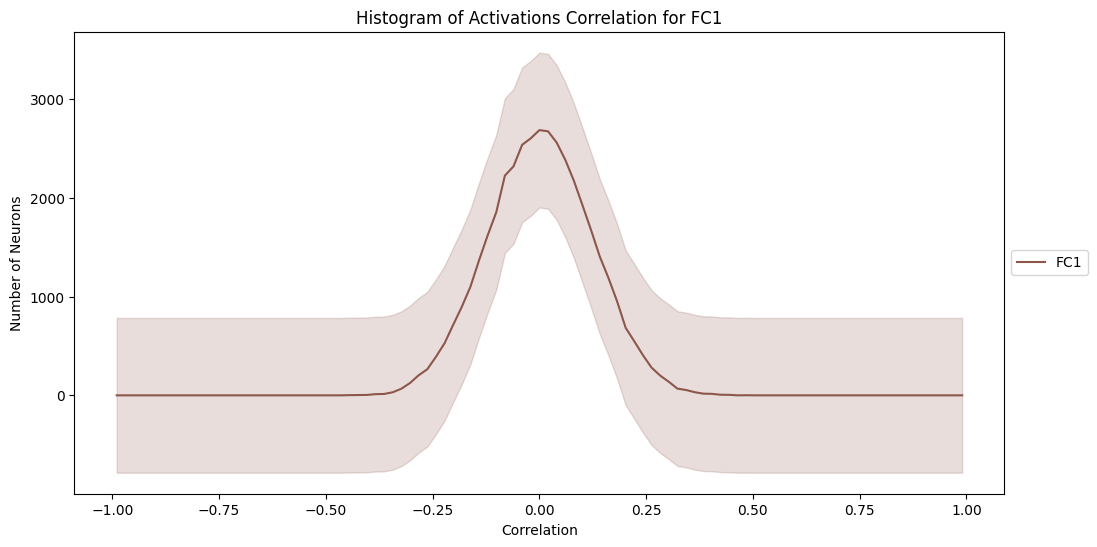

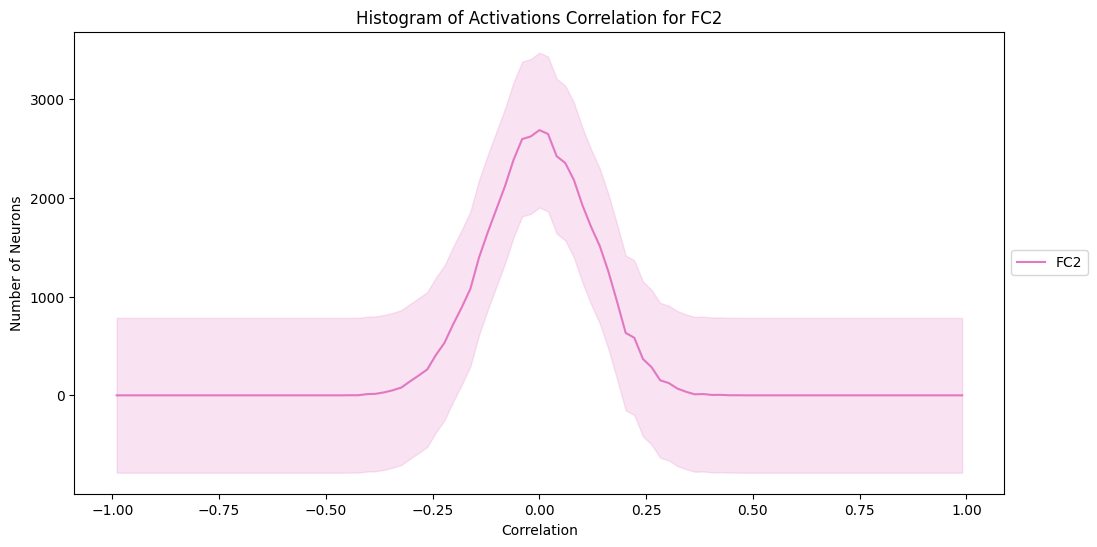

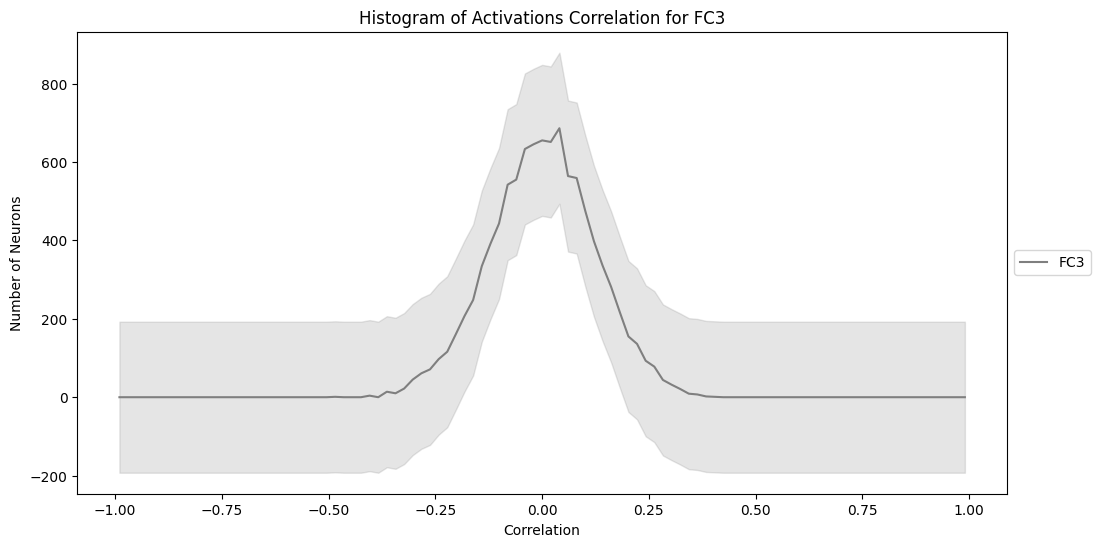

<ipython-input-27-5587268dd0cb>:229: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


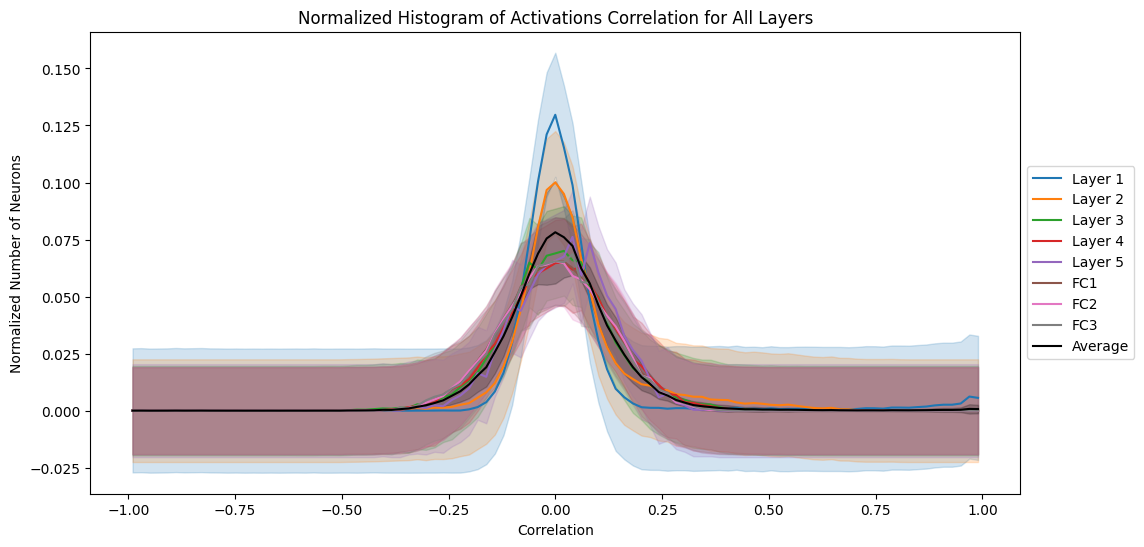

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/left_patch/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('left_patch', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'left_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

olp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_lp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_lp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_lp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, olp_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 1.9357
  WO Activations:
    Mean: 1.8810
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 8.77%
    Percentage of neurons with p-value <= 0.02: 6.90%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.7516
  WO Activations:
    Mean: 1.7082
  T-Test:
    T-statistic: 0.3893
    P-value: 0.5689
    Percentage of neurons with p-value <= 0.05: 10.98%
    Percentage of neurons with p-value <= 0.02: 8.44%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5592
  WO Activations:
    Mean: 0.5539
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 12.35%
    Percentage of neurons with p-value <= 0.02: 7.85%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.2942
  WO Activations:
    Mean: 0.2904
  T-Test:
    T-statistic: nan
    P-value: nan
    Per

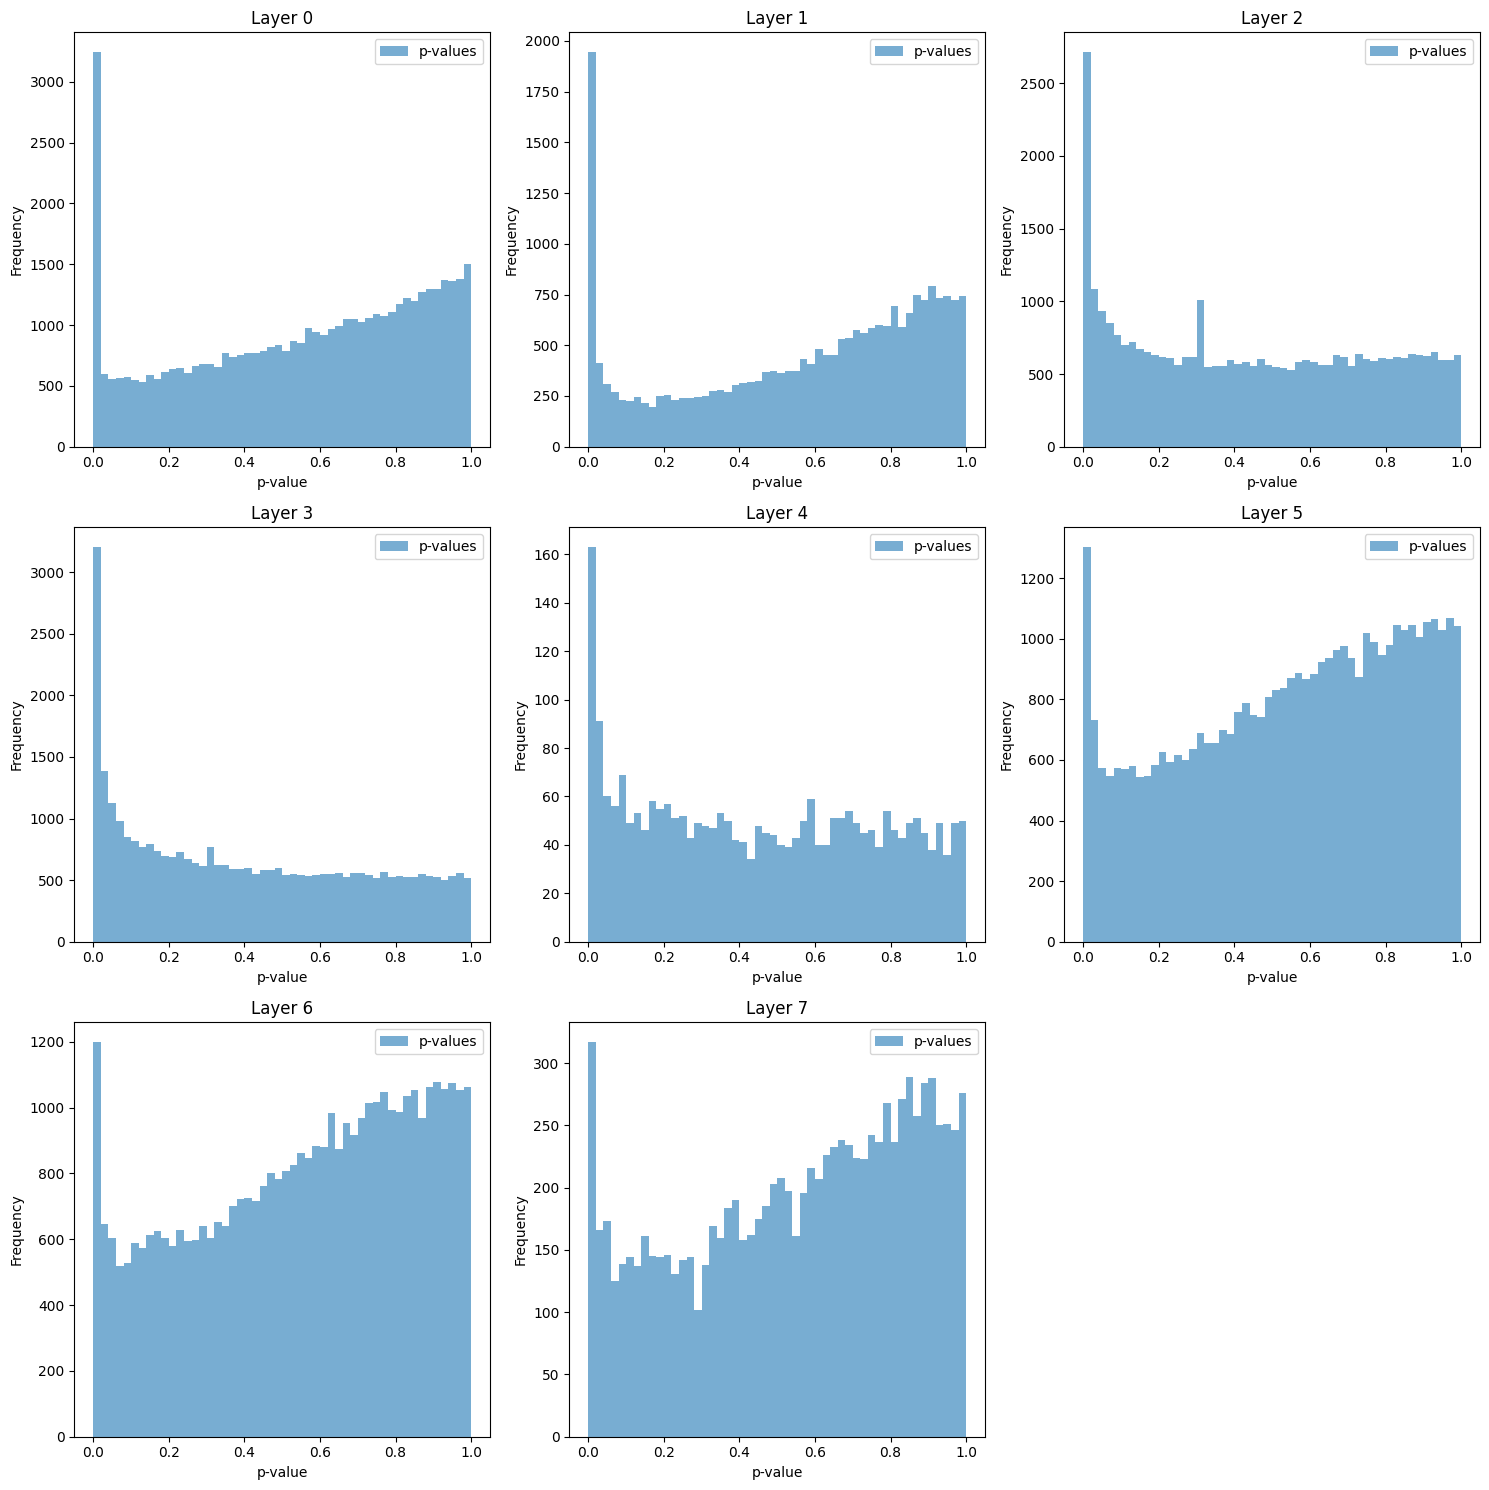

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both left_patch and original conditions
left_patch_activations = {layer: load_activations('left_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(left_patch_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Original vs. center patch

#### Correlations

Computing activations and saving to activations.npy


<ipython-input-29-90a6193b679d>:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


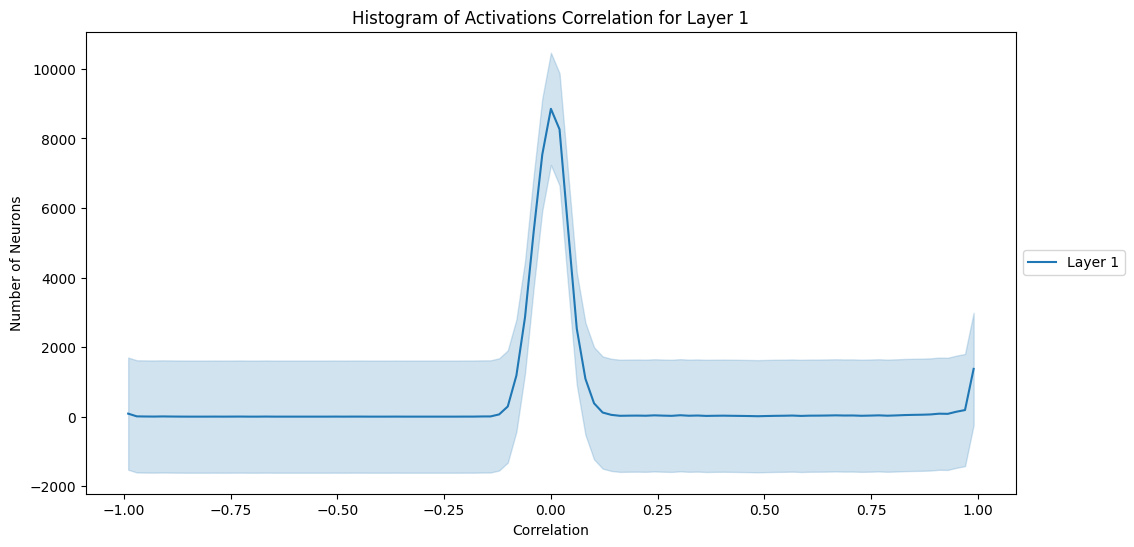

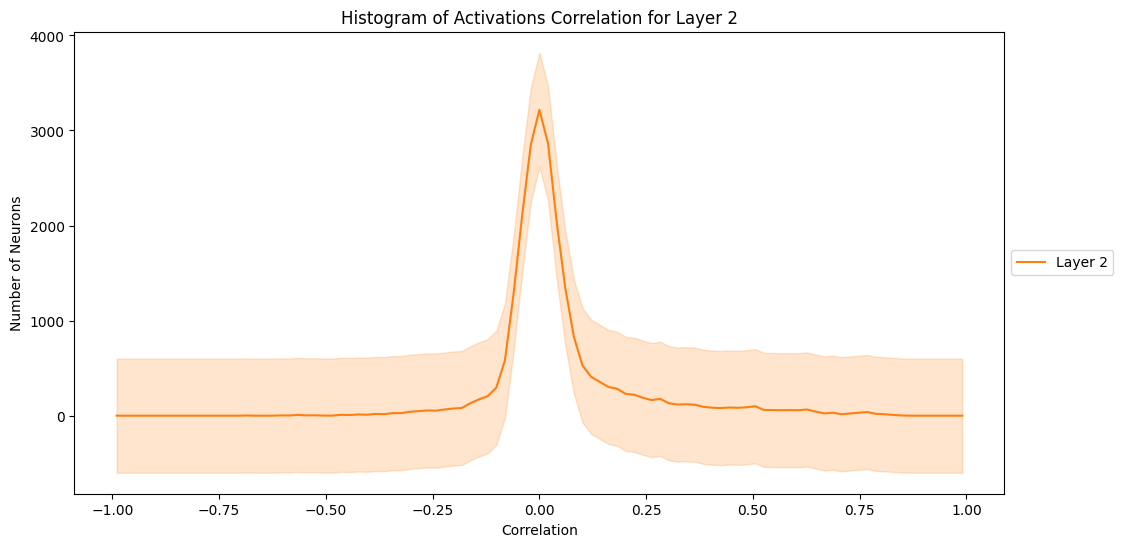

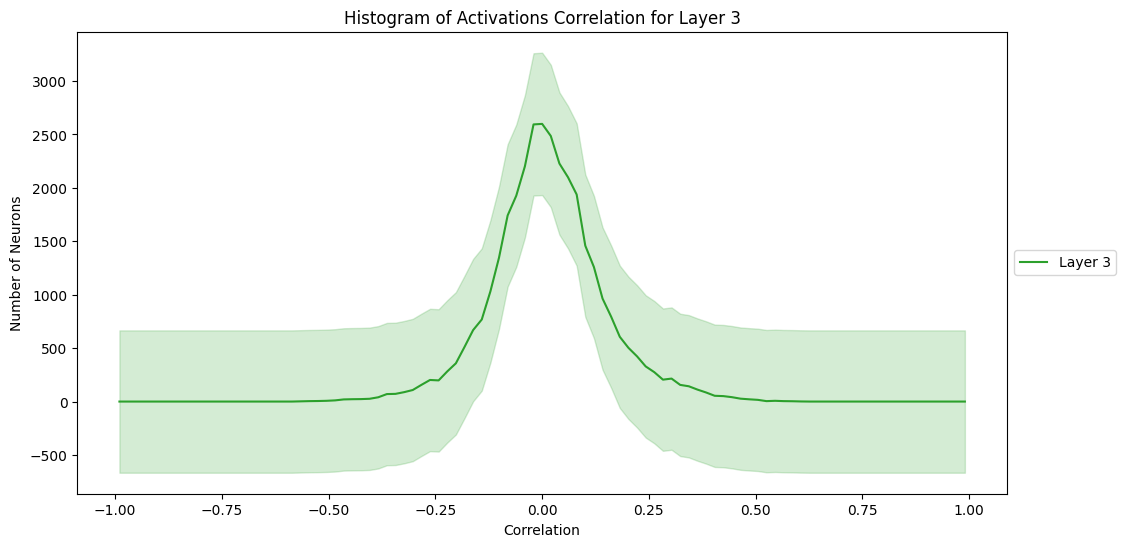

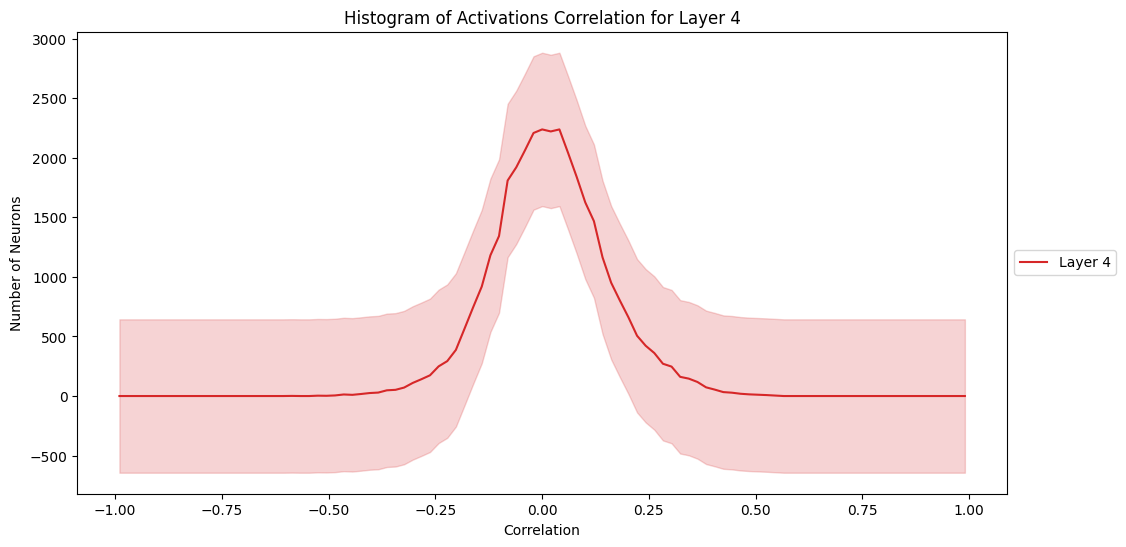

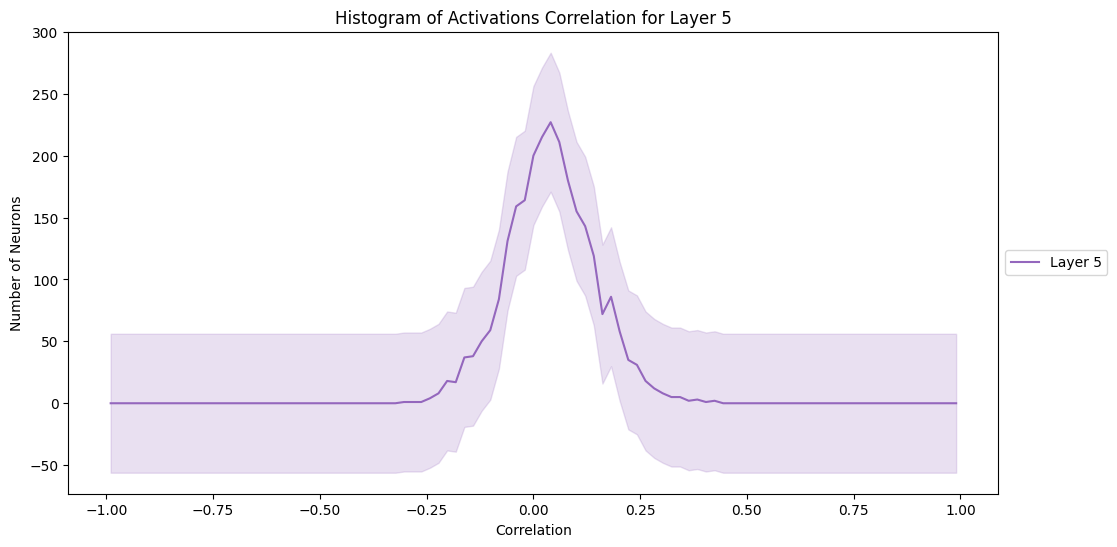

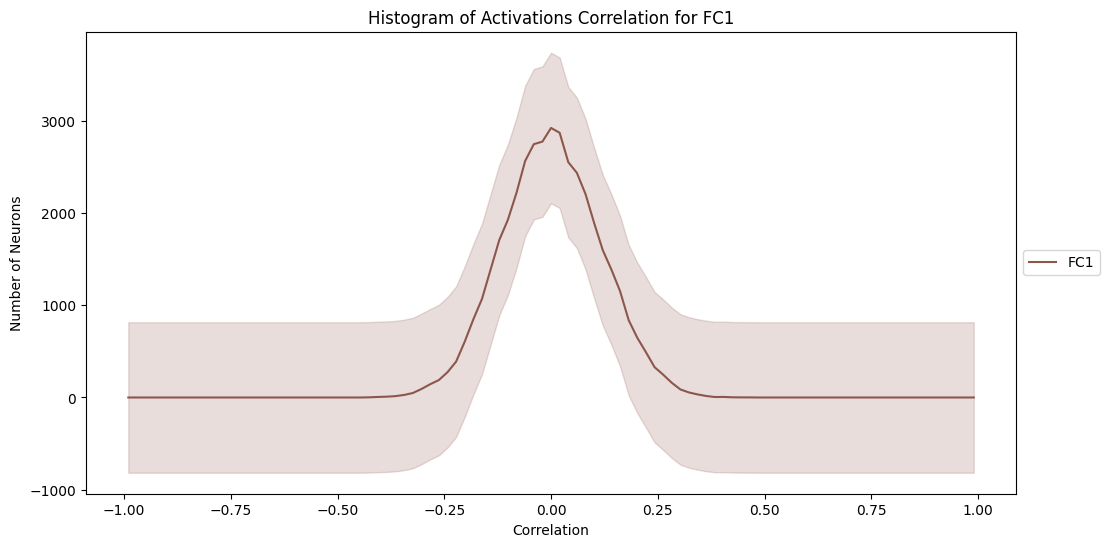

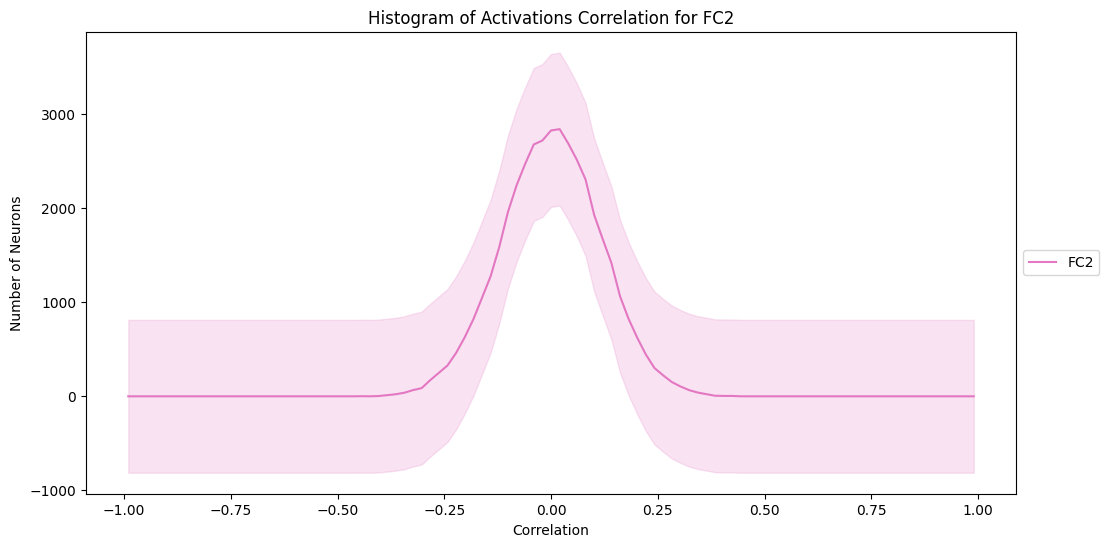

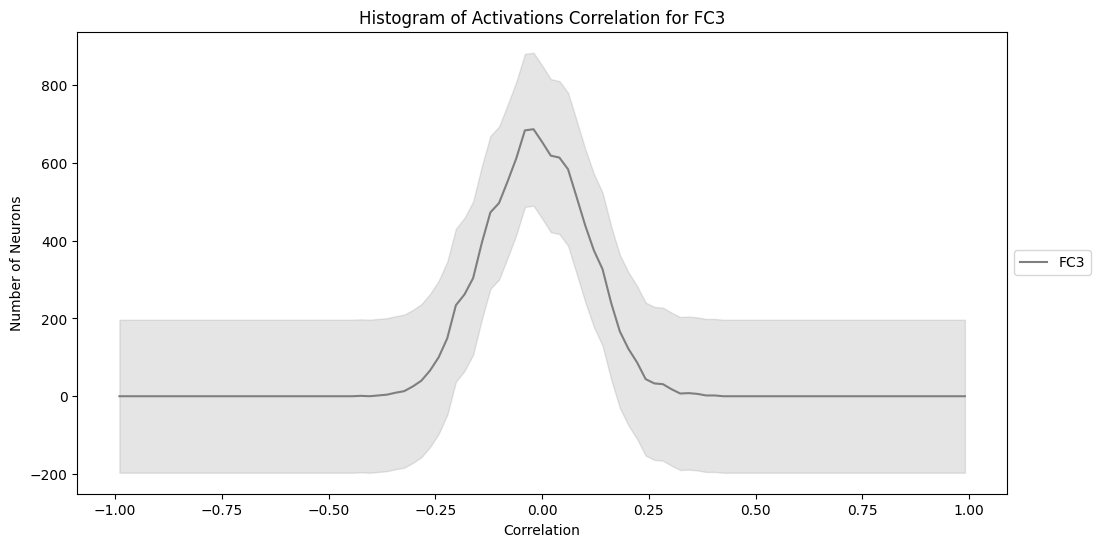

<ipython-input-29-90a6193b679d>:229: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


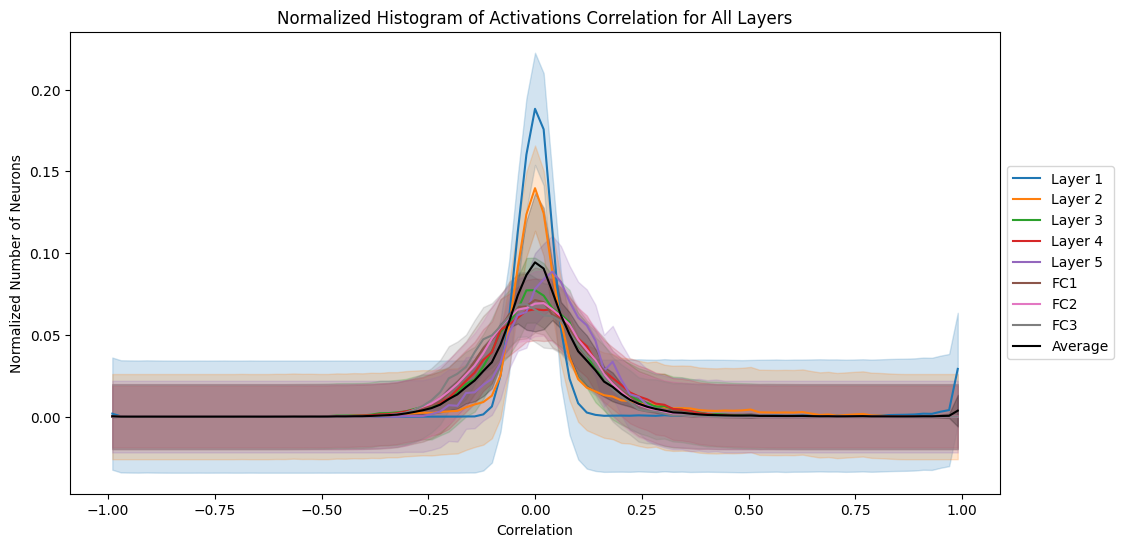

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/center_patch/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/original/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('center_patch', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'center_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_0'
cp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_0'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_cp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_cp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_cp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, org_mnist_folder_path, cp_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-tests

Layer 0:
  WP Activations:
    Mean: 2.0225
  WO Activations:
    Mean: 2.0814
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 6.14%
    Percentage of neurons with p-value <= 0.02: 5.92%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.7571
  WO Activations:
    Mean: 1.8025
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 10.61%
    Percentage of neurons with p-value <= 0.02: 8.50%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5694
  WO Activations:
    Mean: 0.5777
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 11.48%
    Percentage of neurons with p-value <= 0.02: 7.56%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.3050
  WO Activations:
    Mean: 0.3119
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentag

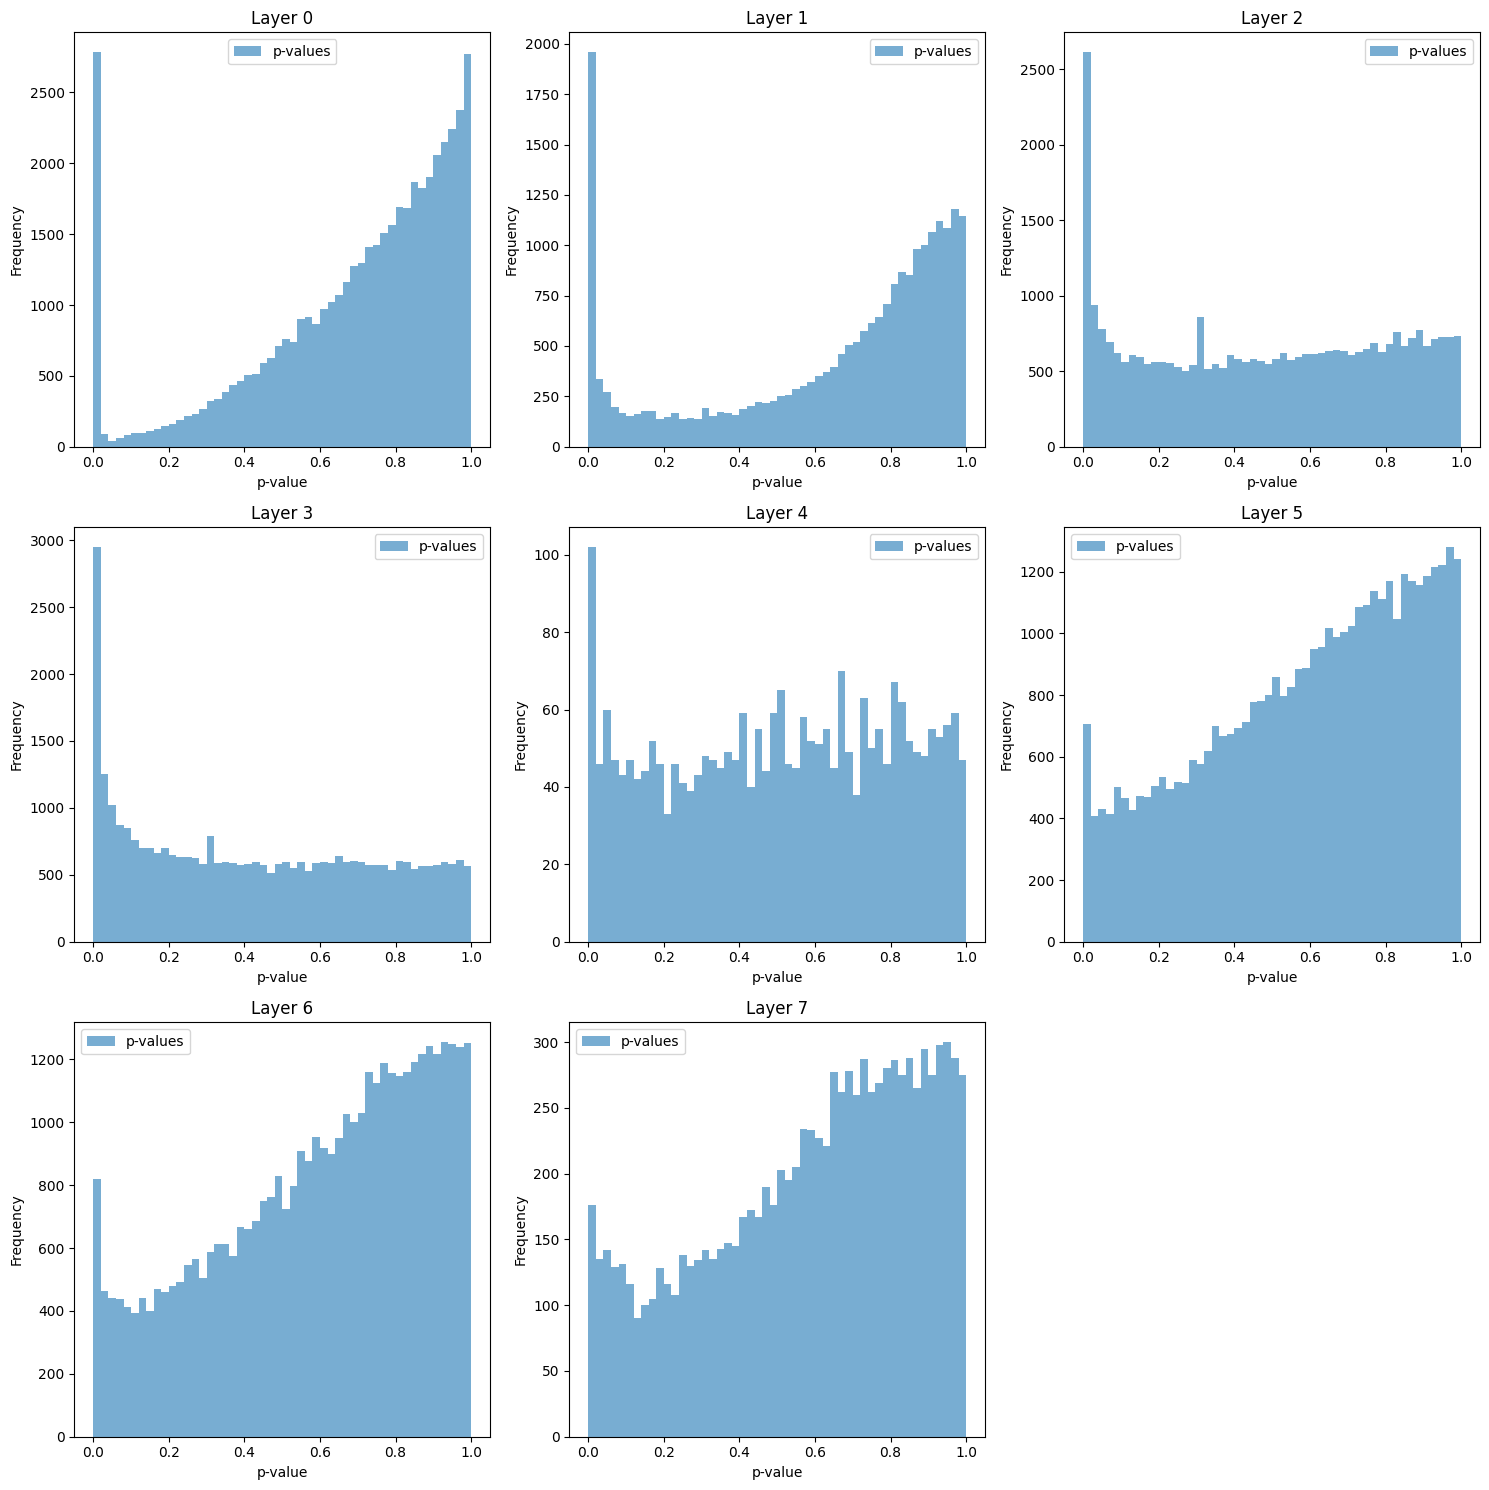

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both original and center_patch conditions
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
center_patch_activations = {layer: load_activations('center_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(original_activations, center_patch_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)


### Center (spur ft.) vs. Left Patch

#### Correlations

Computing activations and saving to activations.npy


<ipython-input-31-1e53e78194e6>:191: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


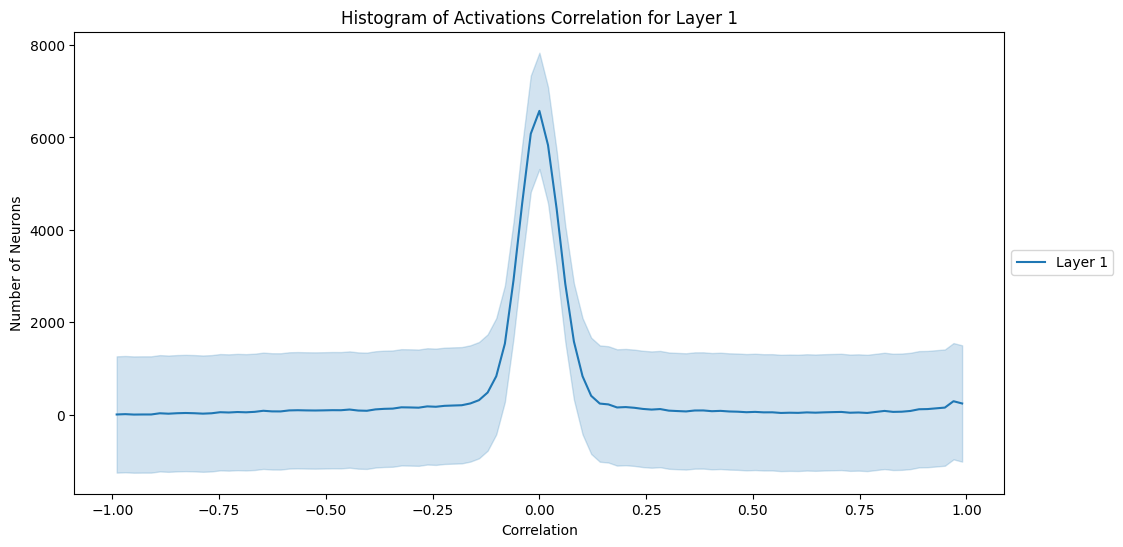

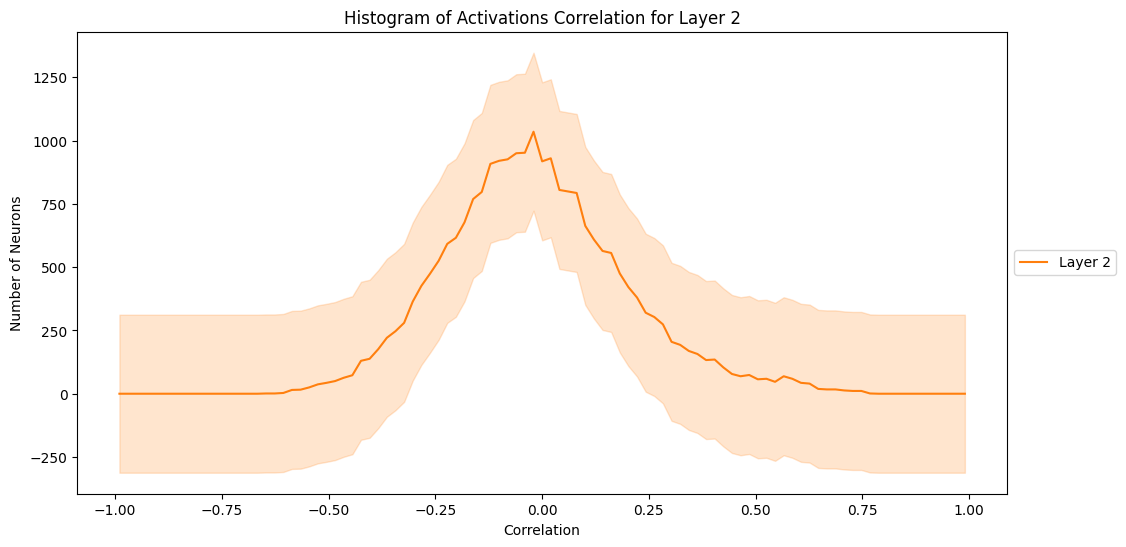

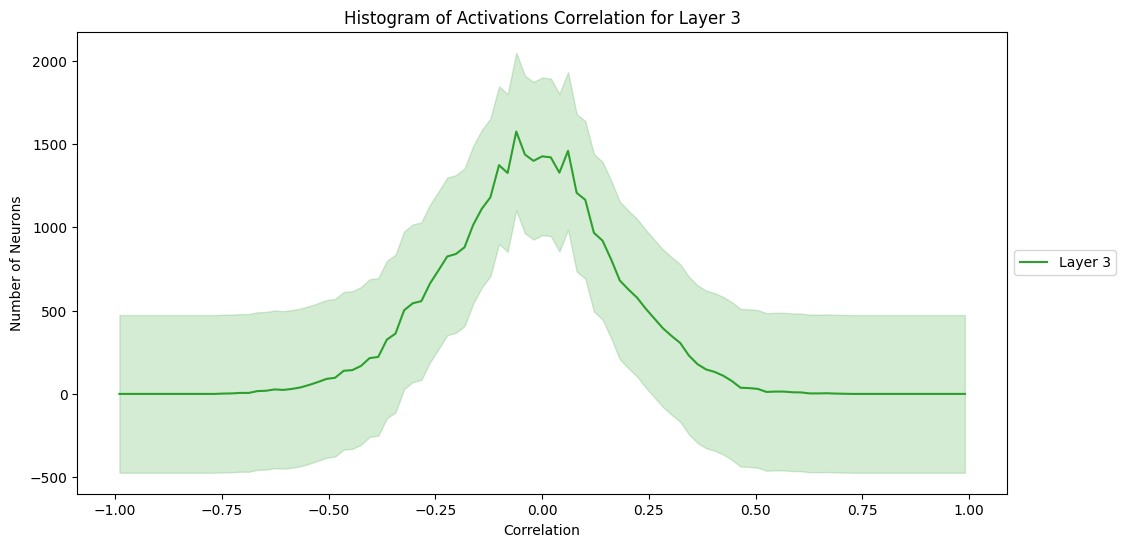

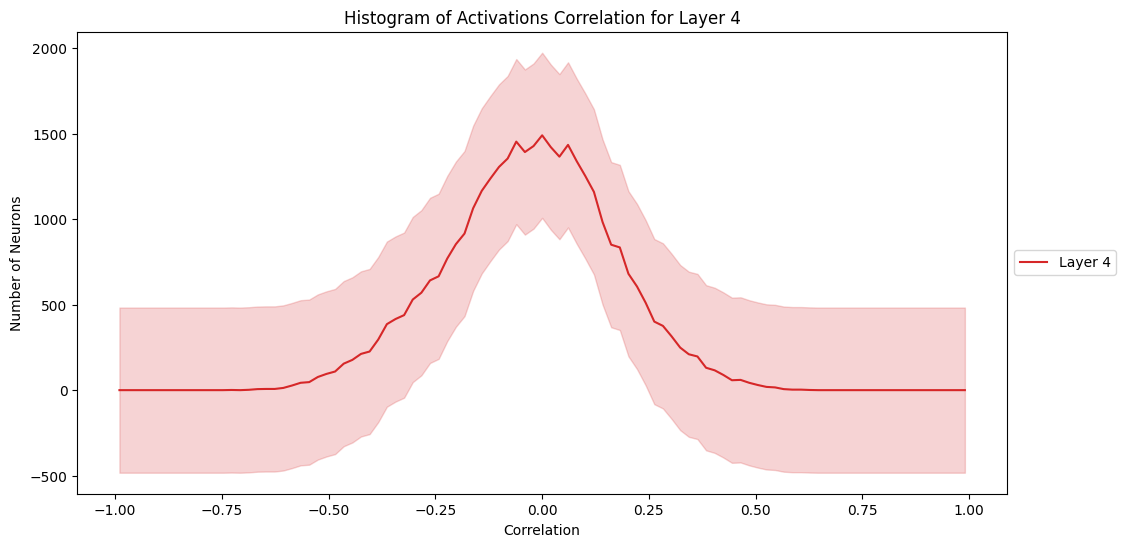

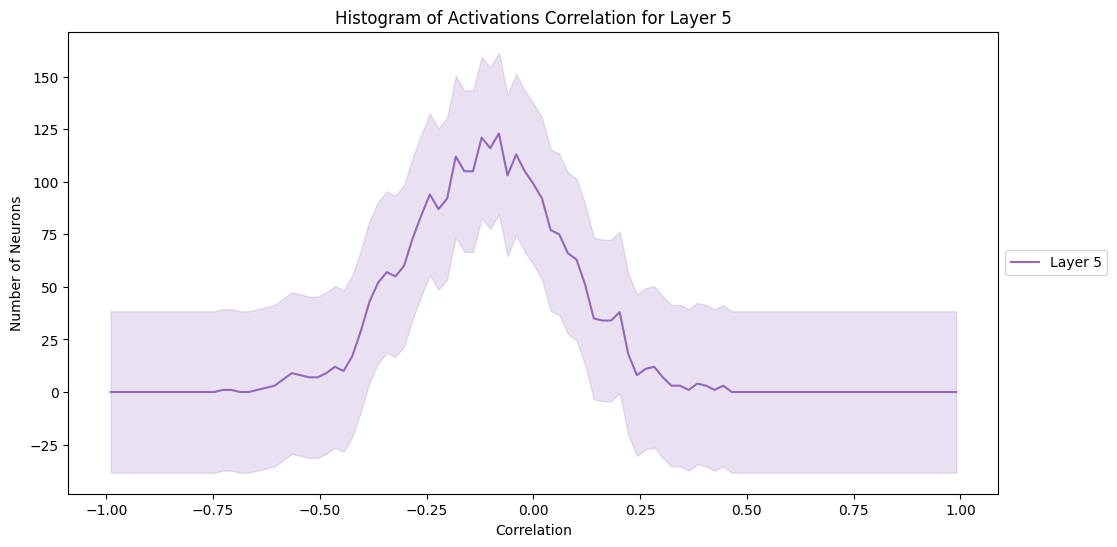

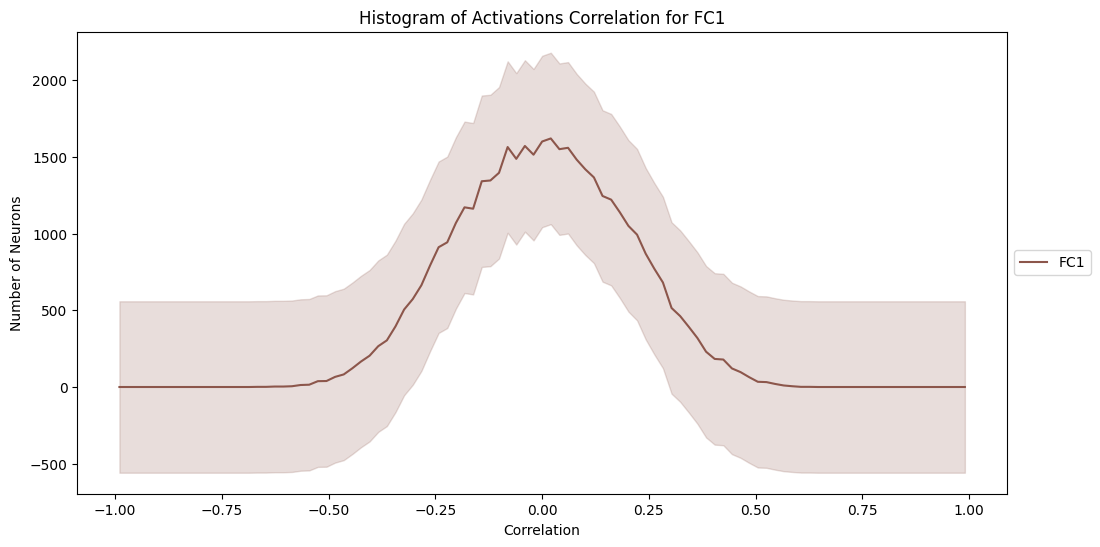

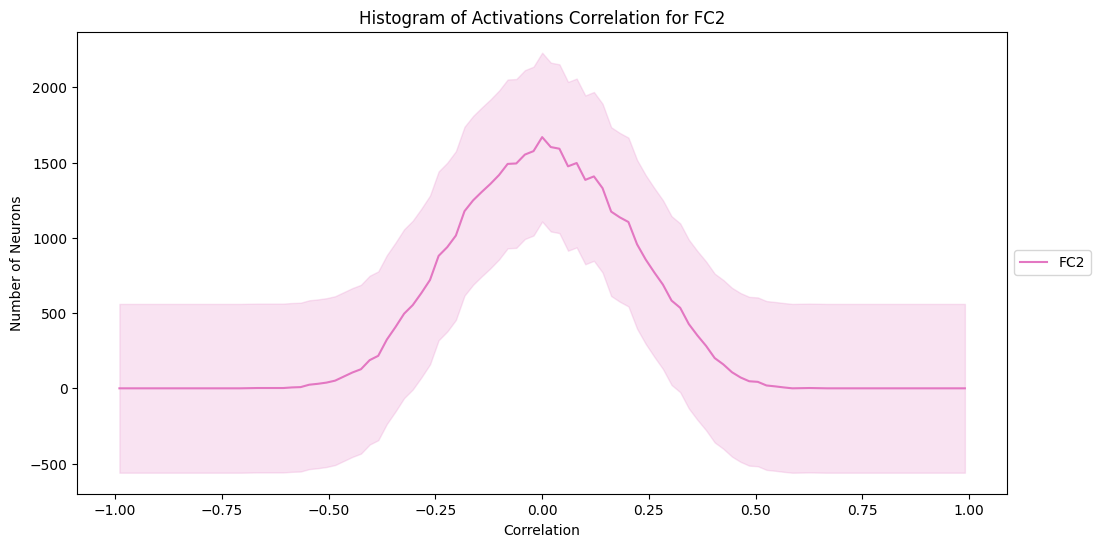

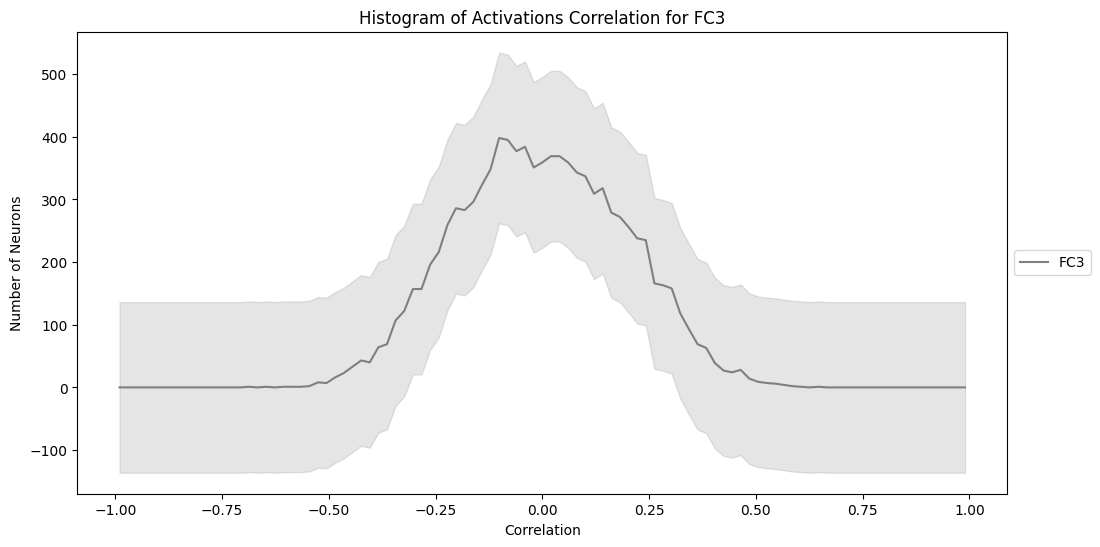

<ipython-input-31-1e53e78194e6>:229: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


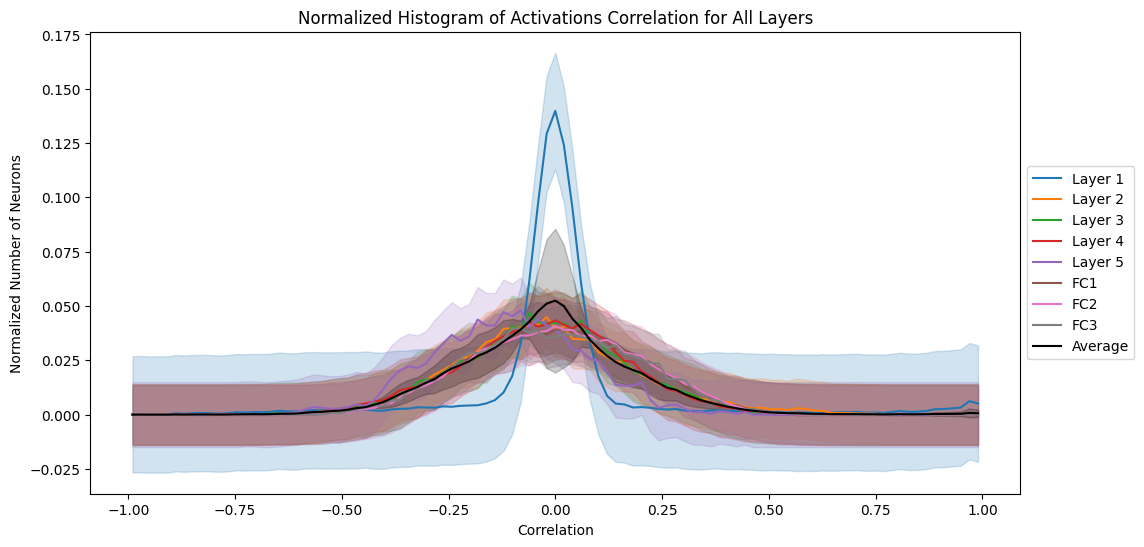

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/center_patch/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/left_patch/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('center_patch', activations_file)
        wo_activations = load_activations('left_patch', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'center_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'left_patch', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

olp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
cp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_cp_lp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_cp_lp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_isic_cp_lp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, olp_mnist_folder_path, cp_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

Layer 0:
  WP Activations:
    Mean: 1.9293
  WO Activations:
    Mean: 1.9425
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 16.20%
    Percentage of neurons with p-value <= 0.02: 14.60%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.6639
  WO Activations:
    Mean: 1.6455
  T-Test:
    T-statistic: 0.0993
    P-value: 0.3454
    Percentage of neurons with p-value <= 0.05: 27.70%
    Percentage of neurons with p-value <= 0.02: 21.30%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5085
  WO Activations:
    Mean: 0.4881
  T-Test:
    T-statistic: nan
    P-value: nan
    Percentage of neurons with p-value <= 0.05: 31.68%
    Percentage of neurons with p-value <= 0.02: 24.34%
--------------------------------------------------
Layer 3:
  WP Activations:
    Mean: 0.2533
  WO Activations:
    Mean: 0.2408
  T-Test:
    T-statistic: nan
    P-value: nan
   

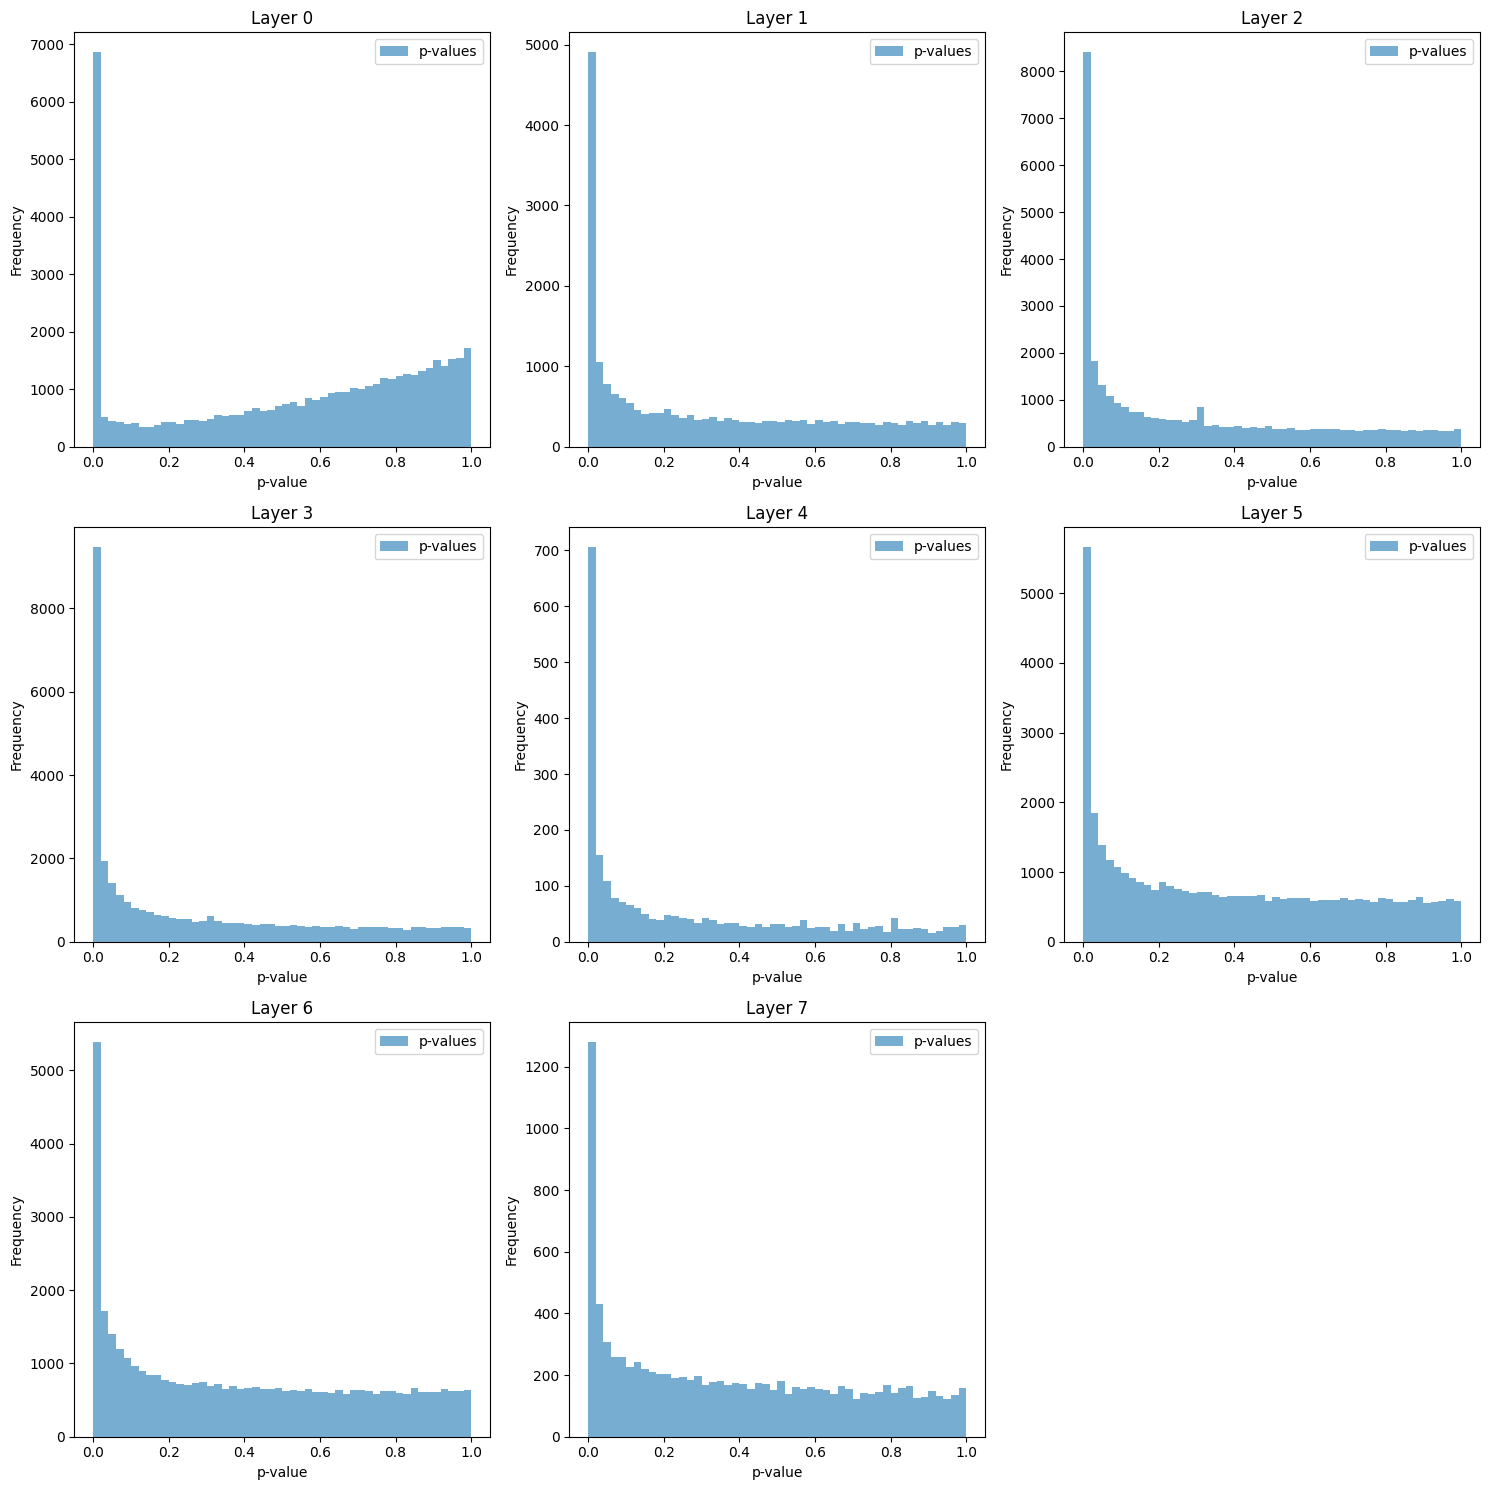

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations_isic/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        t_test_results[layer] = {
            'ttest': ttest_result,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        ttest = results['ttest']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        p_values = ttest.pvalue
        below_or_equal_0_05 = np.mean(p_values <= 0.05) * 100
        below_or_equal_0_02 = np.mean(p_values <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test:")
        print(f"    T-statistic: {ttest.statistic.mean():.4f}")
        print(f"    P-value: {ttest.pvalue.mean():.4f}")
        print(f"    Percentage of neurons with p-value <= 0.05: {below_or_equal_0_05:.2f}%")
        print(f"    Percentage of neurons with p-value <= 0.02: {below_or_equal_0_02:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both left_patch and center_patch conditions
left_patch_activations = {layer: load_activations('left_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
center_patch_activations = {layer: load_activations('center_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(left_patch_activations, center_patch_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
plot_p_values(t_test_results)
